<a href="https://colab.research.google.com/github/thc1006/FLORA/blob/main/0701_FLORA_client_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# @title Cell 1: 環境設定與函式庫匯入（修正版）
!pip install --upgrade opacus -q

import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np, pandas as pd, random, copy, json, os, time, warnings, math, re, contextlib
from collections import deque
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt, seaborn as sns
from dataclasses import dataclass, asdict
from sklearn.cluster import KMeans
from opacus import PrivacyEngine
from opacus.validators import ModuleValidator
from opacus.data_loader import DPDataLoader

# --- 環境設定 ---
try: torch._dynamo.disable()
except Exception: pass
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.filterwarnings("ignore", message=".*overflow encountered.*", category=RuntimeWarning)

pd.options.mode.chained_assignment = None

print("✅ Cell 1: 環境與函式庫準備就緒。")
import opacus
print(f"PyTorch/Opacus 版本: {torch.__version__} / {opacus.__version__}")
print(f"CUDA 是否可用: {torch.cuda.is_available()}")


✅ Cell 1: 環境與函式庫準備就緒。
PyTorch/Opacus 版本: 2.6.0+cu124 / 1.5.4
CUDA 是否可用: True


In [11]:
# @title Cell 2: 🎓 實驗參數設定（7客戶端版）
@dataclass
class TrainingConfig:
    experiment_name: str; output_dir: str
    mode: str = "ClusteredFL"
    random_seed: int = 42
    comm_rounds: int = 35  # 增加通信輪數以適應更多客戶端

    # 修正：7客戶端配置，每個BS獨立成為一個客戶端
    # 客戶端0-3使用eMBB切片，客戶端4-6使用URLLC切片
    client_pairs: tuple = ((1, 0), (2, 0), (3, 0), (4, 0), (5, 2), (6, 2), (7, 2))
    num_clients: int = 7
    num_clients_to_select: int = 7

    local_episodes_per_round: int = 8  # 減少本地訓練輪數以平衡計算負載
    steps_per_episode: int = 400  # 適度減少步數
    batch_size: int = 32  # 減小批次大小
    gamma: float = 0.99

    # --- 穩定性參數 ---
    lr: float = 5e-5  # 降低學習率以提高穩定性
    target_update_freq: int = 12

    # --- RL 探索參數 ---
    epsilon_start: float = 1.0; epsilon_decay: float = 0.9998; epsilon_min: float = 0.08

    # --- 記憶與回放 ---
    memory_capacity: int = 30000  # 減小記憶容量
    replay_start_size: int = 800
    replay_frequency: int = 6
    replay_batches_per_call: int = 1

    # --- 聯邦學習策略參數 ---
    fedprox_mu: float = 0.02  # 增加正則化強度
    num_clusters: int = 3  # 保持3個聚類
    cluster_update_freq: int = 12  # 調整聚類更新頻率

    # --- 功能開關 ---
    enable_dp: bool = False  # 暫時禁用差分隱私
    enable_heterogeneity: bool = True
    enable_compression: bool = True

    # --- DP 參數 ---
    dp_target_epsilon: float = 10.0  # 放寬隱私預算
    dp_target_delta: float = 1e-5
    dp_max_grad_norm: float = 1.0
    dp_noise_multiplier: float = 1.0
    dp_sample_rate: float = 0.02

    # --- 系統設定 ---
    straggler_ratio: float = 0.15  # 減少落後者比例
    dropout_ratio: float = 0.08   # 減少掉線率
    compression_type: str = "quantize_fp16"
    use_pfl_finetune: bool = True
    local_finetune_episodes: int = 20
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    reset_to_random_start: bool = True

    def __post_init__(self):
        if self.mode == 'Centralized' or self.mode == 'Isolated':
            self.enable_heterogeneity = False
            self.enable_compression = False
            self.fedprox_mu = 0
            print(f"🧪 模式 '{self.mode}' 中，異質性、壓縮、FedProx 將被禁用。")
        if self.mode not in ['FedProx', 'ClusteredFL']:
            self.fedprox_mu = 0
        if self.mode == 'Centralized':
            self.enable_dp = False
            print(f"🛡️ 模式 'Centralized' 中，差分隱私已被禁用以作為非隱私基準。")

        if self.enable_dp:
            print(f"⚠️ 差分隱私與強化學習存在兼容性問題，暫時禁用以確保實驗穩定性。")
            self.enable_dp = False

        print(f"🏗️ 7客戶端配置已啟用：")
        print(f"   - eMBB客戶端: BS 1, 8, 15, 22")
        print(f"   - URLLC客戶端: BS 29, 36, 43")

        if self.enable_heterogeneity:
            print(f"🔀 系統異質性已啟用 (掉線率: {self.dropout_ratio}, 落後者率: {self.straggler_ratio}).")
        if self.enable_compression:
            print(f"📡 模型壓縮 ({self.compression_type}) 已啟用。")
        if self.fedprox_mu > 0:
            print(f"💪 FedProx (mu={self.fedprox_mu}) 已啟用。")

    def save(self):
        os.makedirs(self.output_dir, exist_ok=True)
        path = os.path.join(self.output_dir, f'{self.experiment_name}_config.json')
        config_dict = {k: (list(v) if isinstance(v, tuple) else v) for k, v in asdict(self).items()}
        with open(path, 'w') as f: json.dump(config_dict, f, indent=4)

print("✅ Cell 2: TrainingConfig（7客戶端版）定義完成。")


✅ Cell 2: TrainingConfig（7客戶端版）定義完成。


In [12]:
# @title Cell 3: 🧩 數據與環境準備（7客戶端版）
class DataManager:
    def __init__(self, data_path, client_pairs_config):
        print(f"\n[DataManager] 正在從 {data_path} 讀取數據...")
        self.df_kpi = pd.read_parquet(data_path)
        self.client_pairs_config = client_pairs_config
        self._sanitize_column_names(); self._preflight_check()

    def _sanitize_column_names(self):
        sanitized_columns = [re.sub(r'[\[\]\(\)%\s\.-]+', '_', col.strip().lower()).strip('_')
                           for col in self.df_kpi.columns]
        self.df_kpi.columns = sanitized_columns

    def _preflight_check(self):
        print("\n" + "="*20 + " DataManager 7客戶端啟動前預檢查 " + "="*20)
        cols = self.df_kpi.columns.tolist()
        tput_cand = ['throughput_dl_mbps', 'tx_brate_downlink_mbps']
        lat_cand = ['buffer_occupancy_dl_bytes', 'dl_buffer_bytes']

        self.tput_col = next((c for c in tput_cand if c in cols), None)
        self.lat_col = next((c for c in lat_cand if c in cols), None)

        print(f"✅ 清理後的欄位列表 (共 {len(cols)} 個):")
        print(f"   - 吞吐量欄位成功匹配: '{self.tput_col}'" if self.tput_col
              else "   - 吞吐量欄位匹配失敗！")
        print(f"   - 延遲/緩衝區欄位成功匹配: '{self.lat_col}'" if self.lat_col
              else "   - 延遲/緩衝區欄位匹配失敗！")

        # 檢查BS節點的實際可用性
        available_bs = sorted(self.df_kpi['bs_id'].unique())
        print(f"   - 可用BS節點: {available_bs}")

        # 驗證7客戶端配對的有效性
        for i, (bs_id, slice_id) in enumerate(self.client_pairs_config):
            if bs_id not in available_bs:
                raise ValueError(f"客戶端 {i} 的BS {bs_id} 不存在於數據集中")
            slice_type = "eMBB" if slice_id == 0 else "URLLC"
            print(f"   - 客戶端 {i}: BS {bs_id} ({slice_type})")

        print("   - 7客戶端BS配對驗證通過")
        print("="*67 + "\n")

        if not (self.tput_col and self.lat_col):
            raise ValueError("預檢查失敗: 找不到必要的數據欄位。")

    def _get_clean_df(self, gnb_id, slice_id):
        """修正版：7客戶端單切片數據處理"""
        df, bs_col, sl_col = self.df_kpi, 'bs_id', 'slice_id'

        mask = (df[bs_col].astype(int) == int(gnb_id)) & (df[sl_col].astype(int) == int(slice_id))
        subset = df.loc[mask, ['timestamp', self.tput_col, self.lat_col]].copy()

        subset = subset.rename(columns={self.tput_col: 'throughput', self.lat_col: 'latency'})
        subset = subset.dropna()

        # 更嚴格的數據清理
        if not subset.empty:
            subset = subset[
                (subset['throughput'] >= 0) & (subset['throughput'] <= 1000) &
                (subset['latency'] >= 0) & (subset['latency'] <= 1e9)
            ]

        return subset

    def get_client_trajectories(self):
        """修正版：7客戶端單切片軌跡生成"""
        client_trajectories = {}
        print("[DataManager] 正在為7個客戶端生成單切片數據軌跡...")

        for i, (bs_id, slice_id) in enumerate(tqdm(self.client_pairs_config, desc="處理7客戶端數據")):
            try:
                # 每個客戶端使用單一BS的單一切片
                df_slice = self._get_clean_df(bs_id, slice_id)

                if df_slice.empty:
                    print(f"🟡 警告: 客戶端 {i} (BS {bs_id}, Slice {slice_id}) 篩選後無有效數據。")
                    client_trajectories[i] = np.array([])
                    continue

                # 確保數據序列的時間順序性
                df_slice = df_slice.sort_values('timestamp').reset_index(drop=True)

                # 對於單切片場景，我們需要創建合適的狀態表示
                # 使用當前切片數據加上一些派生特徵
                if slice_id == 0:  # eMBB切片
                    # 對於eMBB，專注於吞吐量優化
                    trajectory = np.column_stack([
                        df_slice['throughput'].values,  # 主要吞吐量
                        df_slice['latency'].values * 1e-6,  # 標準化延遲
                        df_slice['throughput'].rolling(5, min_periods=1).mean().values,  # 滑動平均吞吐量
                        df_slice['latency'].rolling(5, min_periods=1).std().fillna(0).values * 1e-6  # 延遲變異性
                    ])
                else:  # URLLC切片
                    # 對於URLLC，專注於延遲優化
                    trajectory = np.column_stack([
                        df_slice['throughput'].values,  # 吞吐量
                        df_slice['latency'].values * 1e-6,  # 主要延遲
                        df_slice['latency'].rolling(5, min_periods=1).mean().values * 1e-6,  # 滑動平均延遲
                        df_slice['throughput'].rolling(5, min_periods=1).std().fillna(0).values  # 吞吐量變異性
                    ])

                trajectory = trajectory.astype(np.float32)
                client_trajectories[i] = trajectory

                slice_type = "eMBB" if slice_id == 0 else "URLLC"
                print(f"   - 客戶端 {i} (BS {bs_id}, {slice_type}): {len(trajectory)} 個時間步")

            except Exception as e:
                print(f"❌ 錯誤: 處理客戶端 {i} 時發生嚴重錯誤: {e}")
                client_trajectories[i] = np.array([])

        num_valid = sum(1 for traj in client_trajectories.values() if traj.size > 0)
        print(f"\n[DataManager] 7客戶端數據處理完成！成功為 {num_valid} / {len(self.client_pairs_config)} 個客戶端創建了環境。")
        return client_trajectories

print("✅ Cell 3: DataManager（7客戶端版）定義完成。")


✅ Cell 3: DataManager（7客戶端版）定義完成。


In [13]:
# @title Cell 4: ⚡ RL 環境與數據處理（7客戶端單切片版）
class PairedEnv:
    def __init__(self, trajectory, config: TrainingConfig, client_id: int):
        self.trajectory, self.config = trajectory, config
        self.client_id = client_id
        self.state_size = trajectory.shape[1] if trajectory.size > 0 else 4
        self.action_size = 3; self.cursor = 0

        # 判斷客戶端類型（eMBB或URLLC）
        self.is_embb_client = client_id < 4  # 前4個客戶端是eMBB
        self.slice_type = "eMBB" if self.is_embb_client else "URLLC"

        self.reset()

    def reset(self):
        if self.trajectory.size == 0:
            return np.zeros(self.state_size, dtype=np.float32)

        max_start = max(0, len(self.trajectory) - self.config.steps_per_episode)
        if self.config.reset_to_random_start and max_start > 0:
            self.cursor = np.random.randint(0, max_start)
        else:
            self.cursor = 0
        return self.trajectory[self.cursor]

    def step(self, action_id: int):
        if self.trajectory.size == 0 or self.cursor >= len(self.trajectory) - 1:
            state = self.trajectory[-1] if self.trajectory.size > 0 else np.zeros(self.state_size, dtype=np.float32)
            return state, 0.0, True, {}

        self.cursor += 1
        done = self.cursor >= len(self.trajectory) - 1
        state = self.trajectory[self.cursor]
        reward = self._compute_reward_with_action(state, action_id)
        return state, reward, done, {}

    def _compute_reward_with_action(self, state: np.ndarray, action_id: int) -> float:
        """修正版：針對單切片場景的獎勵函數"""
        if len(state) < 4:
            return 0.0

        tput, latency, feature3, feature4 = state

        # 動作策略權重
        if action_id == 0:      # 保守策略
            aggression = 0.3
        elif action_id == 1:    # 平衡策略
            aggression = 0.5
        else:                   # 激進策略
            aggression = 0.7

        if self.is_embb_client:
            # eMBB客戶端：專注於吞吐量最大化
            tput_reward = np.log1p(tput) * (0.7 + 0.3 * aggression)
            stability_penalty = abs(feature4) * 0.1  # 吞吐量變異性懲罰
            latency_penalty = np.tanh(latency) * 0.2
            reward_val = tput_reward - latency_penalty - stability_penalty
        else:
            # URLLC客戶端：專注於延遲最小化
            latency_reward = -np.tanh(latency) * (0.8 + 0.2 * aggression)
            tput_bonus = np.log1p(tput) * 0.3  # 適度的吞吐量獎勵
            stability_penalty = abs(feature4) * 0.1  # 吞吐量變異性懲罰
            reward_val = latency_reward + tput_bonus - stability_penalty

        return float(np.nan_to_num(reward_val, nan=0.0, posinf=10.0, neginf=-10.0))

class RLDataset(Dataset):
    def __init__(self, memory_deque):
        self.data = list(memory_deque)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        state, action, reward, next_state, done = self.data[idx]
        return (torch.from_numpy(state).float(), torch.tensor(action).long(),
                torch.tensor(reward).float(), torch.from_numpy(next_state).float(),
                torch.tensor(done).bool())

def get_data_loader_corrected(agent_memory: deque, batch_size: int, device: str):
    """修正版：移除drop_last參數以兼容DPDataLoader"""
    if len(agent_memory) < batch_size:
        return None
    dataset = RLDataset(agent_memory)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True,
                     pin_memory=(device == 'cuda'))

print("✅ Cell 4: RL 環境（7客戶端單切片版）定義完成。")


✅ Cell 4: RL 環境（7客戶端單切片版）定義完成。


In [14]:
# @title Cell 5: 🛡️ 核心學習代理（最終修正版）
class RLAgent:
    def __init__(self, state_size: int, action_size: int, config: TrainingConfig, client_id: int,
                 dataset_size: int, is_eval_agent: bool = False):
        self.state_size, self.action_size, self.config = state_size, action_size, config
        self.client_id, self.dataset_size = client_id, dataset_size
        self.device = torch.device(config.device)
        self.mu = self.config.fedprox_mu
        self.gamma, self.epsilon = config.gamma, config.epsilon_start
        self.memory = deque(maxlen=config.memory_capacity)
        self.global_params, self.privacy_engine = None, None
        self.is_eval_agent = is_eval_agent

        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()
        self.target_model.eval()

        self.optimizer = optim.Adam(self.model.parameters(), lr=config.lr)
        self.criterion = nn.MSELoss()

        # 修正：檢查是否真正需要差分隱私
        if self.config.enable_dp and not self.is_eval_agent and self.config.mode != 'Centralized':
            self._activate_privacy_engine()

    def _build_model(self):
        """修正版：使用更適合差分隱私的網絡架構"""
        model = nn.Sequential(
            nn.Linear(self.state_size, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, self.action_size)
        ).to(self.device)

        if self.config.enable_dp and not self.is_eval_agent:
            if not ModuleValidator.is_valid(model):
                model = ModuleValidator.fix(model)

        return model

    def _activate_privacy_engine(self):
        """修正版：完全避免差分隱私以解決兼容性問題"""
        print(f"[C-{self.client_id}] 🛡️ 檢測到差分隱私設定，但強化學習環境暫時禁用...")
        print(f"   - 🟡 將在標準模式下繼續運行以確保穩定性")
        self.privacy_engine = None
        # 注意：實際部署時可考慮使用其他隱私保護機制

    def replay(self, num_batches: int):
        """修正版：簡化的經驗回放，避免與差分隱私衝突"""
        if len(self.memory) < self.config.batch_size:
            return 0.0

        data_loader = get_data_loader_corrected(self.memory, self.config.batch_size, self.device)
        if data_loader is None:
            return 0.0

        total_loss, batches_processed = 0.0, 0
        self.model.train()

        for i, batch in enumerate(data_loader):
            if i >= num_batches:
                break

            self.optimizer.zero_grad()
            states, actions, rewards, next_states, dones = [item.to(self.device) for item in batch]
            actions, rewards, dones = actions.view(-1, 1), rewards.view(-1, 1), dones.view(-1, 1)

            # Q-learning更新
            current_q = self.model(states).gather(1, actions)
            with torch.no_grad():
                max_next_q = self.target_model(next_states).max(1)[0].unsqueeze(1)
                target_q = rewards + (self.gamma * max_next_q * (~dones))

            loss = self.criterion(current_q, target_q)

            # 修正：FedProx正則化項
            if self.config.mode in ['FedProx', 'ClusteredFL'] and self.mu > 0 and self.global_params:
                proximal_term = 0.0
                for local_param, global_param in zip(self.model.parameters(), self.global_params):
                    proximal_term += torch.sum((local_param - global_param.to(self.device))**2)
                loss += (self.mu / 2) * proximal_term

            loss.backward()

            # 修正：標準梯度裁剪
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.config.dp_max_grad_norm)

            self.optimizer.step()
            total_loss += loss.item()
            batches_processed += 1

        return total_loss / batches_processed if batches_processed > 0 else 0.0

    def get_privacy_cost(self):
        """修正版：由於禁用差分隱私，返回0"""
        return 0.0

    def set_global_params(self, state_dict):
        with torch.no_grad():
            self.global_params = [p.clone().detach().cpu() for p in state_dict.values()]

    def act(self, state):
        if not self.is_eval_agent and np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        with torch.no_grad():
            q_values = self.model(torch.from_numpy(state).float().unsqueeze(0).to(self.device))
        return q_values.argmax().item()

    def remember(self, *args):
        self.memory.append(args)

    def get_clean_state_dict(self):
        """修正版：簡化狀態字典獲取"""
        return self.model.state_dict()

    def update_target_model(self):
        """修正版：標準目標模型更新"""
        self.target_model.load_state_dict(self.model.state_dict())

    def get_model_weights_flat(self):
        with torch.no_grad():
            return torch.cat([p.view(-1) for p in self.model.parameters()]).cpu().numpy()

    def get_model_for_upload(self):
        state_dict = self.get_clean_state_dict()
        if self.config.enable_compression:
            return {k: v.half() for k, v in state_dict.items()}
        return state_dict

print("✅ Cell 5: RLAgent（最終修正版）定義完成。")


✅ Cell 5: RLAgent（最終修正版）定義完成。


In [15]:
# @title Cell 6: 📡 聯邦學習伺服器（修正版）
class FLServer:
    def __init__(self, config: TrainingConfig):
        self.config = config
        self.client_to_cluster = {}
        self.cluster_models = {}
        # 修正：添加聚類歷史記錄，避免數據洩漏
        self.clustering_history = []

    @torch.no_grad()
    def aggregate_weighted(self, client_updates: list[tuple[dict, int]]):
        if not client_updates:
            return None

        # 解壓縮模型（如果需要）
        decompressed_updates = []
        for state_dict, num_points in client_updates:
            if (self.config.enable_compression and
                next(iter(state_dict.values())).dtype == torch.float16):
                state_dict = {k: v.float() for k, v in state_dict.items()}
            decompressed_updates.append((state_dict, num_points))

        total_data_points = sum(num_points for _, num_points in decompressed_updates)
        if total_data_points == 0:
            return copy.deepcopy(decompressed_updates[0][0])

        # 加權聚合
        global_dict = {k: torch.zeros_like(v, device='cpu')
                      for k, v in decompressed_updates[0][0].items()}

        for state_dict, num_points in decompressed_updates:
            weight = num_points / total_data_points
            for k, v in state_dict.items():
                global_dict[k] += v.cpu() * weight

        return global_dict

    def distribute_model(self, agents: dict, global_model_state: dict):
        if not global_model_state:
            return

        for cid, agent in agents.items():
            current_model_state = global_model_state

            # 修正：使用歷史聚類信息，避免未來信息洩漏
            if self.config.mode == 'ClusteredFL':
                cluster_id = self.client_to_cluster.get(cid)
                if cluster_id is not None and cluster_id in self.cluster_models:
                    current_model_state = self.cluster_models[cluster_id]

            agent.model.load_state_dict(current_model_state, strict=False)
            agent.set_global_params(current_model_state)

    def update_clusters(self, agents: dict, current_round: int):
        """修正版：防止數據洩漏的聚類更新"""
        if len(agents) < self.config.num_clusters:
            return

        print(f"\n[分群] 正在為 {len(agents)} 個客戶端重新計算群組（回合 {current_round}）...")
        client_ids = list(agents.keys())

        try:
            # 修正：使用當前回合之前的模型權重進行聚類
            weight_vectors = np.array([agents[cid].get_model_weights_flat() for cid in client_ids])

            if np.isnan(weight_vectors).any() or np.isinf(weight_vectors).any():
                print("   - 警告: 模型權重中包含 NaN/Inf，跳過本輪分群。")
                return

            # 修正：使用固定的random_state確保可重現性
            kmeans = KMeans(
                n_clusters=self.config.num_clusters,
                random_state=self.config.random_seed + current_round,  # 添加回合數確保確定性
                n_init=10,
                max_iter=100
            ).fit(weight_vectors)

            # 更新聚類分配
            new_clustering = {client_ids[i]: label for i, label in enumerate(kmeans.labels_)}

            # 記錄聚類變化
            if hasattr(self, 'client_to_cluster') and self.client_to_cluster:
                changes = sum(1 for cid in client_ids
                            if self.client_to_cluster.get(cid, -1) != new_clustering[cid])
                print(f"   - 聚類變更: {changes} 個客戶端")

            self.client_to_cluster = new_clustering

            # 記錄聚類歷史（用於分析，不用於訓練）
            self.clustering_history.append({
                'round': current_round,
                'clustering': copy.deepcopy(new_clustering)
            })

            print("   - ✅ 分群完成。新的群組分配如下:")
            for cluster_id in range(self.config.num_clusters):
                clients_in_cluster = [cid for cid, c_id in self.client_to_cluster.items()
                                    if c_id == cluster_id]
                print(f"     > 群組 {cluster_id}: 客戶端 {clients_in_cluster}")

        except Exception as e:
            print(f"   - 錯誤: 聚類更新失敗: {e}")

print("✅ Cell 6: FLServer（修正版）定義完成。")


✅ Cell 6: FLServer（修正版）定義完成。


In [16]:
# @title Cell 7: 🚀 ExperimentRunner（修正版）
import scipy.stats as stats
import time
from tqdm.notebook import tqdm

class ExperimentRunner:
    def __init__(self, config: TrainingConfig, data_manager: DataManager, all_trajectories, client_pairs):
        self.config, self.data_manager, self.server = config, data_manager, FLServer(config)
        self.training_history, self.evaluation_results, self.privacy_costs = [], [], []
        self._set_seeds()

        print("\n[ExperimentRunner] 正在初始化客戶端環境與代理...")
        # 修正：添加 client_id 參數
        self.client_envs = {cid: PairedEnv(traj, config, cid) for cid, traj in all_trajectories.items()
                           if traj.size > 0}

        if not self.client_envs:
            raise ValueError("DataManager 未能為任何客戶端創建有效的環境。")

        self.config.num_clients = len(self.client_envs)

        if self.config.mode == "Centralized":
            central_config = copy.deepcopy(config)
            central_config.enable_dp = False
            pooled_trajectory = np.vstack([traj for traj in all_trajectories.values() if traj.size > 0])
            print(f" - [集中式] 已將 {len(all_trajectories)} 個客戶端的數據匯集，總共 {len(pooled_trajectory)} 個時間步。")

            # 修正：添加 client_id 參數（集中式模式使用 client_id=0）
            self.central_env = PairedEnv(pooled_trajectory, central_config, 0)
            self.central_agent = RLAgent(
                self.central_env.state_size, self.central_env.action_size,
                central_config, client_id=0, dataset_size=len(pooled_trajectory), is_eval_agent=False
            )
            self.client_agents = {}
        else:
            self.client_agents = {}
            for cid, env in self.client_envs.items():
                dataset_size = len(env.trajectory) if env.trajectory.size > 0 else 1
                self.client_agents[cid] = RLAgent(
                    env.state_size, env.action_size, config=config, client_id=cid,
                    dataset_size=dataset_size, is_eval_agent=False
                )

        # 初始化全局模型狀態
        if self.client_agents:
            self.global_model_state = self.client_agents[next(iter(self.client_agents))].get_clean_state_dict()
        else:
            self.global_model_state = self.central_agent.get_clean_state_dict()

        self.config.save()
        print("[ExperimentRunner] 初始化完成。")

    def _set_seeds(self):
        seed = self.config.random_seed
        torch.manual_seed(seed); torch.cuda.manual_seed(seed); torch.cuda.manual_seed_all(seed)
        np.random.seed(seed); random.seed(seed)
        torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = False

    def _train_agent_locally(self, agent: RLAgent, env: PairedEnv, episodes: int, is_finetune: bool = False):
        """修正版：更穩定的本地訓練"""
        agent.model.train()
        total_loss, total_reward, training_steps, episode_count = 0.0, 0.0, 0, 0

        if episodes == 0:
            return 0.0, 0.0, 0.0

        for episode in range(episodes):
            state, episode_reward, done = env.reset(), 0.0, False
            step_count = 0

            for step in range(1, self.config.steps_per_episode + 1):
                action = agent.act(state)
                next_state, reward, done, _ = env.step(action)
                agent.remember(state, action, reward, next_state, done)
                state = next_state
                episode_reward += reward
                step_count += 1

                # 經驗回放
                can_replay = len(agent.memory) > self.config.replay_start_size
                is_replay_time = step % self.config.replay_frequency == 0

                if can_replay and is_replay_time:
                    loss = agent.replay(num_batches=self.config.replay_batches_per_call)
                    total_loss += loss
                    training_steps += 1

                if done:
                    break

            total_reward += episode_reward
            episode_count += 1

            # 目標網絡更新
            if (episode + 1) % self.config.target_update_freq == 0:
                agent.update_target_model()

            # epsilon衰減
            if not agent.is_eval_agent and not is_finetune and agent.epsilon > self.config.epsilon_min:
                agent.epsilon *= self.config.epsilon_decay

        avg_loss = total_loss / training_steps if training_steps > 0 else 0.0
        avg_reward = total_reward / episode_count if episode_count > 0 else 0.0
        privacy_cost = agent.get_privacy_cost() if training_steps > 0 and agent.privacy_engine else 0.0

        return avg_loss, avg_reward, privacy_cost

    def _evaluate_agent(self, env: PairedEnv, model_state: dict, num_episodes: int = 15) -> float:
        """評估代理性能"""
        if env.trajectory.size == 0:
            return 0.0

        eval_config = copy.deepcopy(self.config)
        eval_config.enable_dp = False
        eval_agent = RLAgent(
            env.state_size, env.action_size, eval_config, client_id=-1,
            dataset_size=1, is_eval_agent=True
        )
        eval_agent.model.load_state_dict(model_state)
        eval_agent.model.eval()
        eval_agent.epsilon = 0.0

        total_reward = 0
        for _ in range(num_episodes):
            state, episode_reward, done = env.reset(), 0, False
            for _ in range(self.config.steps_per_episode):
                action = eval_agent.act(state)
                next_state, reward, done, _ = env.step(action)
                episode_reward += reward
                state = next_state
                if done:
                    break
            total_reward += episode_reward

        return total_reward / num_episodes

    def _run_federated_training(self):
        """修正版：聯邦訓練主循環"""
        print(f"\n[模式] 執行聯邦式訓練 ({self.config.mode})")
        available_client_ids = list(self.client_agents.keys())
        progress_bar = tqdm(range(self.config.comm_rounds), desc=f"{self.config.mode} Training")

        for comm_round in progress_bar:
            # 修正：傳遞當前回合數以避免數據洩漏
            if (self.config.mode == 'ClusteredFL' and comm_round > 0 and
                comm_round % self.config.cluster_update_freq == 0):
                self.server.update_clusters(self.client_agents, comm_round)

            # 客戶端選擇
            num_to_select = min(self.config.num_clients_to_select, len(available_client_ids))
            selected_ids = np.random.choice(available_client_ids, num_to_select, replace=False)
            participating_ids = list(selected_ids)
            straggler_ids = set()

            # 系統異質性模擬
            if self.config.enable_heterogeneity and len(participating_ids) > 1:
                num_dropouts = int(self.config.dropout_ratio * len(participating_ids))
                if num_dropouts > 0 and len(participating_ids) > num_dropouts:
                    dropout_ids = set(np.random.choice(participating_ids, num_dropouts, replace=False))
                    participating_ids = [cid for cid in participating_ids if cid not in dropout_ids]

                if participating_ids and len(participating_ids) > 1:
                    num_stragglers = int(self.config.straggler_ratio * len(participating_ids))
                    if num_stragglers > 0:
                        straggler_ids = set(np.random.choice(participating_ids, num_stragglers, replace=False))

            if not participating_ids:
                print(f" (Round {comm_round}) 🟡 所有客戶端均掉線，跳過本輪。")
                self.training_history.append({
                    'round': comm_round, 'avg_reward': np.nan, 'avg_loss': np.nan
                })
                continue

            # 分發模型
            participating_agents = {cid: self.client_agents[cid] for cid in participating_ids}
            self.server.distribute_model(participating_agents, self.global_model_state)

            # 本地訓練
            client_updates, round_losses, round_rewards, round_privacy_costs = [], [], [], []

            for cid in participating_ids:
                agent, env = self.client_agents[cid], self.client_envs[cid]
                episodes = (self.config.local_episodes_per_round // 2 if cid in straggler_ids
                           else self.config.local_episodes_per_round)

                loss, reward, privacy_cost = self._train_agent_locally(agent, env, episodes)

                client_updates.append((agent.get_model_for_upload(), len(env.trajectory)))
                round_losses.append(loss)
                round_rewards.append(reward)

                if self.config.enable_dp and privacy_cost > 0:
                    round_privacy_costs.append(privacy_cost)

            # 聚合更新
            if self.config.mode == 'ClusteredFL':
                client_updates_by_cluster = {i: [] for i in range(self.config.num_clusters)}
                for i, (model_update, num_points) in enumerate(client_updates):
                    cid = participating_ids[i]
                    cluster_id = self.server.client_to_cluster.get(cid, 0)
                    client_updates_by_cluster[cluster_id].append((model_update, num_points))

                new_cluster_models = []
                for cluster_id, updates in client_updates_by_cluster.items():
                    if updates:
                        updated_cluster_model = self.server.aggregate_weighted(updates)
                        self.server.cluster_models[cluster_id] = updated_cluster_model
                        new_cluster_models.append((updated_cluster_model, sum(n for _, n in updates)))

                if new_cluster_models:
                    self.global_model_state = self.server.aggregate_weighted(new_cluster_models)
            else:
                if client_updates:
                    self.global_model_state = self.server.aggregate_weighted(client_updates)

            # 記錄訓練歷史
            avg_reward = np.mean(round_rewards) if round_rewards else 0
            avg_loss = np.mean(round_losses) if round_losses else 0
            self.training_history.append({
                'round': comm_round, 'avg_reward': avg_reward, 'avg_loss': avg_loss
            })

            if self.config.enable_dp and round_privacy_costs:
                self.privacy_costs.append({
                    'round': comm_round, 'epsilon': np.mean(round_privacy_costs)
                })

            progress_bar.set_postfix(reward=f"{avg_reward:.2f}", loss=f"{avg_loss:.4f}")

    def _run_centralized_training(self):
        print(f"\n[模式] 執行集中式訓練 (Centralized)")
        progress_bar = tqdm(range(self.config.comm_rounds), desc="Centralized Training")

        num_clients_per_round = min(self.config.num_clients_to_select, self.config.num_clients)
        equivalent_episodes = self.config.local_episodes_per_round * num_clients_per_round

        for r in progress_bar:
            loss, reward, _ = self._train_agent_locally(self.central_agent, self.central_env,
                                                       episodes=equivalent_episodes)
            self.training_history.append({'round': r, 'avg_reward': reward, 'avg_loss': loss})
            self.privacy_costs.append({'round': r, 'epsilon': 0.0})
            progress_bar.set_postfix(reward=f"{reward:.2f}", loss=f"{loss:.4f}")

        self.global_model_state = self.central_agent.get_clean_state_dict()

    def _run_isolated_training(self):
        print(f"\n[模式] 執行孤立式訓練 (Isolated)")
        progress_bar = tqdm(range(self.config.comm_rounds), desc="Isolated Training Rounds")

        num_clients_per_round = min(self.config.num_clients_to_select, self.config.num_clients)
        equivalent_episodes_per_client = int(np.ceil((self.config.local_episodes_per_round * num_clients_per_round) / self.config.num_clients))

        for r in progress_bar:
            round_rewards, round_losses, round_epsilons = [], [], []
            for cid, agent in self.client_agents.items():
                env = self.client_envs[cid]
                loss, reward, privacy_cost = self._train_agent_locally(agent, env,
                                                                      episodes=equivalent_episodes_per_client)
                round_rewards.append(reward)
                round_losses.append(loss)
                if self.config.enable_dp and privacy_cost > 0:
                    round_epsilons.append(privacy_cost)

            avg_reward = np.mean(round_rewards) if round_rewards else np.nan
            avg_loss = np.mean(round_losses) if round_losses else np.nan
            self.training_history.append({'round': r, 'avg_reward': avg_reward, 'avg_loss': avg_loss})

            if self.config.enable_dp and round_epsilons:
                self.privacy_costs.append({'round': r, 'epsilon': np.mean(round_epsilons)})

            progress_bar.set_postfix(
                reward=f"{avg_reward:.2f}" if not np.isnan(avg_reward) else "NaN",
                loss=f"{avg_loss:.4f}" if not np.isnan(avg_loss) else "NaN"
            )

    def _run_final_evaluation_and_pfl(self):
        print("\n[評估] 正在執行最終評估...")
        final_model_path = os.path.join(self.config.output_dir, f'{self.config.experiment_name}_global_model.pt')
        if self.global_model_state:
            torch.save(self.global_model_state, final_model_path)

        for cid, env in tqdm(self.client_envs.items(), desc="最終評估"):
            eval_row = {'client_id': cid}
            seed = self.config.random_seed + cid

            # 決定基礎模型和個人化模型
            if self.config.mode == "Isolated":
                base_model_state = self.client_agents[cid].get_clean_state_dict()
                personalized_model_state = base_model_state
            else:
                base_model_state = self.global_model_state
                personalized_model_state = base_model_state

            if self.config.mode == 'ClusteredFL':
                cluster_id = self.server.client_to_cluster.get(cid)
                if cluster_id is not None and cluster_id in self.server.cluster_models:
                    personalized_model_state = self.server.cluster_models[cluster_id]

            # 執行評估
            torch.manual_seed(seed); np.random.seed(seed); random.seed(seed)
            eval_row['reward_global'] = self._evaluate_agent(env, base_model_state)

            if personalized_model_state is base_model_state:
                eval_row['reward_personalized'] = eval_row['reward_global']
            else:
                torch.manual_seed(seed); np.random.seed(seed); random.seed(seed)
                eval_row['reward_personalized'] = self._evaluate_agent(env, personalized_model_state)

            # PFL Fine-tuning評估
            if self.config.use_pfl_finetune:
                finetune_config = copy.deepcopy(self.config)
                finetune_config.enable_dp = False
                finetune_agent = RLAgent(env.state_size, env.action_size, finetune_config, cid,
                                        dataset_size=len(env.trajectory), is_eval_agent=False)
                finetune_agent.epsilon = 0.01
                finetune_agent.model.load_state_dict(personalized_model_state)
                self._train_agent_locally(finetune_agent, env, self.config.local_finetune_episodes, is_finetune=True)

                torch.manual_seed(seed); np.random.seed(seed); random.seed(seed)
                finetuned_model_state = finetune_agent.get_clean_state_dict()
                eval_row['reward_pfl_finetuned'] = self._evaluate_agent(env, finetuned_model_state)
            else:
                eval_row['reward_pfl_finetuned'] = eval_row['reward_personalized']

            self.evaluation_results.append(eval_row)

    def run(self):
        print(f"\n{'='*20} 🏃♂️ 開始執行實驗: {self.config.experiment_name} ({self.config.mode}) {'='*20}")
        start_time = time.time()

        if self.config.mode == 'Centralized':
            self._run_centralized_training()
        elif self.config.mode == 'Isolated':
            self._run_isolated_training()
        elif self.config.mode in ['FedAvg', 'FedProx', 'ClusteredFL']:
            self._run_federated_training()
        else:
            raise ValueError(f"未知的實驗模式: {self.config.mode}")

        self._run_final_evaluation_and_pfl()

        total_time = (time.time() - start_time) / 60
        print(f"✅ 實驗 {self.config.experiment_name} 完成！總耗時: {total_time:.2f} 分鐘")

        # 保存結果
        if self.training_history:
            pd.DataFrame(self.training_history).to_csv(
                os.path.join(self.config.output_dir, f'{self.config.experiment_name}_training_history.csv'),
                index=False
            )
        if self.evaluation_results:
            pd.DataFrame(self.evaluation_results).to_csv(
                os.path.join(self.config.output_dir, f'{self.config.experiment_name}_evaluation_results.csv'),
                index=False
            )
        if self.config.enable_dp and self.privacy_costs:
            pd.DataFrame(self.privacy_costs).to_csv(
                os.path.join(self.config.output_dir, f'{self.config.experiment_name}_privacy_costs.csv'),
                index=False
            )

        return pd.DataFrame(self.evaluation_results), pd.DataFrame(self.training_history)

print("✅ Cell 7: ExperimentRunner（修正版）定義完成。")


✅ Cell 7: ExperimentRunner（修正版）定義完成。


In [17]:
# @title Cell 8: 🎬 主要執行區塊（7客戶端版）

def run_experiment_wrapper(config_dict: dict, data_path: str, all_trajectories, client_pairs):
    try:
        config = TrainingConfig(**config_dict)
        print(f"\n{'='*25} 準備執行7客戶端實驗: {config.experiment_name} | Seed: {config.random_seed} {'='*25}")
        data_manager = DataManager(data_path, config.client_pairs)
        runner = ExperimentRunner(config, data_manager, all_trajectories, client_pairs)
        eval_res, history_res = runner.run()
        print(f"\n--- 7客戶端實驗 {config.experiment_name} (Seed {config.random_seed}) 評估結果 ---")
        print(eval_res.round(2))
    except Exception as e:
        print(f"\n❌ 7客戶端實驗 {config_dict.get('experiment_name')} (Seed {config_dict.get('random_seed')}) 執行失敗！")
        import traceback
        traceback.print_exc()

# --- 環境與路徑設定 ---
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    BASE_WORK_DIR = "/content/drive/MyDrive/FRL_Slicing_Sim"
except ImportError:
    BASE_WORK_DIR = ".FRL_Slicing_Sim"

os.makedirs(BASE_WORK_DIR, exist_ok=True)
DATA_PATH = os.path.join(BASE_WORK_DIR, "kpi_traces_final_robust0.parquet")
print(f"✅ 數據檔案路徑設定為: {DATA_PATH}")

# --- 7客戶端配對設定 ---
MODES_TO_RUN = ["Centralized", "Isolated", "FedAvg", "FedProx", "ClusteredFL"]
SEEDS = [42, 2024, 888]

# 7客戶端配置：每個BS獨立成為一個客戶端
# 前4個客戶端使用eMBB切片，後3個客戶端使用URLLC切片
BASE_CLIENT_PAIRS = ((1, 0), (2, 0), (3, 0), (4, 0), (5, 2), (6, 2), (7, 2))
NUM_TOTAL_CLIENTS = len(BASE_CLIENT_PAIRS)

print(f"✅ 7客戶端配對已設定：")
print(f"   - eMBB客戶端: 客戶端0(BS1), 客戶端1(BS8), 客戶端2(BS15), 客戶端3(BS22)")
print(f"   - URLLC客戶端: 客戶端4(BS29), 客戶端5(BS36), 客戶端6(BS43)")

# --- 數據準備 ---
print(f"\n[數據準備] 正在為 {NUM_TOTAL_CLIENTS} 個獨立客戶端準備數據...")
data_manager = DataManager(DATA_PATH, BASE_CLIENT_PAIRS)
original_trajectories = data_manager.get_client_trajectories()
print(f"✅ {len(original_trajectories)} 個客戶端的數據軌跡已準備就緒。")

# --- 執行迴圈 ---
BASE_OUTPUT_DIR = os.path.join(BASE_WORK_DIR, "outputs_7clients_single_slice")

for seed in SEEDS:
    for mode in MODES_TO_RUN:
        exp_name = f"{mode}_7clients_run"
        output_dir = os.path.join(BASE_OUTPUT_DIR, f"seed_{seed}", mode)

        config_params = {
            "experiment_name": exp_name,
            "output_dir": output_dir,
            "mode": mode,
            "random_seed": seed,
            "client_pairs": BASE_CLIENT_PAIRS,
            "num_clients": NUM_TOTAL_CLIENTS,
            "num_clients_to_select": NUM_TOTAL_CLIENTS,
            "comm_rounds": 35,  # 增加通信輪數
            "local_episodes_per_round": 8,  # 適當的本地訓練輪數
            "steps_per_episode": 400,
            "num_clusters": 3,  # 保持3個聚類
            "enable_dp": False,  # 暫時禁用差分隱私
            "batch_size": 32,
            "lr": 5e-5,  # 較低的學習率
            "fedprox_mu": 0.02,  # 增加正則化
        }

        run_experiment_wrapper(config_params, DATA_PATH, original_trajectories, BASE_CLIENT_PAIRS)

print("\n\n🎉🎉🎉 7客戶端聯邦強化學習實驗均已執行完畢！ 🎉🎉🎉")


Mounted at /content/drive
✅ 數據檔案路徑設定為: /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet
✅ 7客戶端配對已設定：
   - eMBB客戶端: 客戶端0(BS1), 客戶端1(BS8), 客戶端2(BS15), 客戶端3(BS22)
   - URLLC客戶端: 客戶端4(BS29), 客戶端5(BS36), 客戶端6(BS43)

[數據準備] 正在為 7 個獨立客戶端準備數據...

[DataManager] 正在從 /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet 讀取數據...

==================== DataManager 7客戶端啟動前預檢查 ====================
✅ 清理後的欄位列表 (共 38 個):
   - 吞吐量欄位成功匹配: 'throughput_dl_mbps'
   - 延遲/緩衝區欄位成功匹配: 'buffer_occupancy_dl_bytes'
   - 可用BS節點: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]
   - 客戶端 0: BS 1 (eMBB)
   - 客戶端 1: BS 2 (eMBB)
   - 客戶端 2: BS 3 (eMBB)
   - 客戶端 3: BS 4 (eMBB)
   - 客戶端 4: BS 5 (URLLC)
   - 客戶端 5: BS 6 (URLLC)
   - 客戶端 6: BS 7 (URLLC)
   - 7客戶端BS配對驗證通過

[DataManager] 正在為7個客戶端生成單切片數據軌跡...


處理7客戶端數據:   0%|          | 0/7 [00:00<?, ?it/s]

   - 客戶端 0 (BS 1, eMBB): 16093 個時間步
   - 客戶端 1 (BS 2, eMBB): 16221 個時間步
   - 客戶端 2 (BS 3, eMBB): 26742 個時間步
   - 客戶端 3 (BS 4, eMBB): 67588 個時間步
   - 客戶端 4 (BS 5, URLLC): 856501 個時間步
   - 客戶端 5 (BS 6, URLLC): 869516 個時間步
   - 客戶端 6 (BS 7, URLLC): 838787 個時間步

[DataManager] 7客戶端數據處理完成！成功為 7 / 7 個客戶端創建了環境。
✅ 7 個客戶端的數據軌跡已準備就緒。
🧪 模式 'Centralized' 中，異質性、壓縮、FedProx 將被禁用。
🛡️ 模式 'Centralized' 中，差分隱私已被禁用以作為非隱私基準。
🏗️ 7客戶端配置已啟用：
   - eMBB客戶端: BS 1, 8, 15, 22
   - URLLC客戶端: BS 29, 36, 43

========================= 準備執行7客戶端實驗: Centralized_7clients_run | Seed: 42 =========================

[DataManager] 正在從 /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet 讀取數據...

==================== DataManager 7客戶端啟動前預檢查 ====================
✅ 清理後的欄位列表 (共 38 個):
   - 吞吐量欄位成功匹配: 'throughput_dl_mbps'
   - 延遲/緩衝區欄位成功匹配: 'buffer_occupancy_dl_bytes'
   - 可用BS節點: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]
   - 客戶端 0: BS 1 (eMBB)
   - 客戶端 1: BS 2 (eM

Centralized Training:   0%|          | 0/35 [00:00<?, ?it/s]


[評估] 正在執行最終評估...


最終評估:   0%|          | 0/7 [00:00<?, ?it/s]

✅ 實驗 Centralized_7clients_run 完成！總耗時: 17.22 分鐘

--- 7客戶端實驗 Centralized_7clients_run (Seed 42) 評估結果 ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned
0          0         298.34               298.34                310.49
1          1         257.60               257.60                272.65
2          2         316.39               316.39                333.93
3          3         380.93               380.93                404.81
4          4          10.75                10.75                 10.75
5          5          10.83                10.83                 10.83
6          6          10.07                10.07                 10.07
🧪 模式 'Isolated' 中，異質性、壓縮、FedProx 將被禁用。
🏗️ 7客戶端配置已啟用：
   - eMBB客戶端: BS 1, 8, 15, 22
   - URLLC客戶端: BS 29, 36, 43

========================= 準備執行7客戶端實驗: Isolated_7clients_run | Seed: 42 =========================

[DataManager] 正在從 /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet 讀取數據...

===================

Isolated Training Rounds:   0%|          | 0/35 [00:00<?, ?it/s]


[評估] 正在執行最終評估...


最終評估:   0%|          | 0/7 [00:00<?, ?it/s]

✅ 實驗 Isolated_7clients_run 完成！總耗時: 15.92 分鐘

--- 7客戶端實驗 Isolated_7clients_run (Seed 42) 評估結果 ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned
0          0         310.59               310.59                310.59
1          1         273.01               273.01                272.95
2          2         335.42               335.42                335.45
3          3         404.81               404.81                404.81
4          4          10.73                10.73                 10.73
5          5          10.83                10.83                 10.83
6          6          10.07                10.07                 10.07
🏗️ 7客戶端配置已啟用：
   - eMBB客戶端: BS 1, 8, 15, 22
   - URLLC客戶端: BS 29, 36, 43
🔀 系統異質性已啟用 (掉線率: 0.08, 落後者率: 0.15).
📡 模型壓縮 (quantize_fp16) 已啟用。

========================= 準備執行7客戶端實驗: FedAvg_7clients_run | Seed: 42 =========================

[DataManager] 正在從 /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet 讀取數據...

==

FedAvg Training:   0%|          | 0/35 [00:00<?, ?it/s]


[評估] 正在執行最終評估...


最終評估:   0%|          | 0/7 [00:00<?, ?it/s]

✅ 實驗 FedAvg_7clients_run 完成！總耗時: 14.83 分鐘

--- 7客戶端實驗 FedAvg_7clients_run (Seed 42) 評估結果 ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned
0          0         289.40               289.40                309.58
1          1         254.79               254.79                262.15
2          2         312.36               312.36                327.13
3          3         377.04               377.04                396.72
4          4          10.73                10.73                 10.73
5          5          10.83                10.83                 10.83
6          6          10.07                10.07                 10.07
🏗️ 7客戶端配置已啟用：
   - eMBB客戶端: BS 1, 8, 15, 22
   - URLLC客戶端: BS 29, 36, 43
🔀 系統異質性已啟用 (掉線率: 0.08, 落後者率: 0.15).
📡 模型壓縮 (quantize_fp16) 已啟用。
💪 FedProx (mu=0.02) 已啟用。

========================= 準備執行7客戶端實驗: FedProx_7clients_run | Seed: 42 =========================

[DataManager] 正在從 /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robus

FedProx Training:   0%|          | 0/35 [00:00<?, ?it/s]


[評估] 正在執行最終評估...


最終評估:   0%|          | 0/7 [00:00<?, ?it/s]

✅ 實驗 FedProx_7clients_run 完成！總耗時: 17.65 分鐘

--- 7客戶端實驗 FedProx_7clients_run (Seed 42) 評估結果 ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned
0          0         289.36               289.36                309.91
1          1         254.38               254.38                262.57
2          2         312.89               312.89                327.12
3          3         377.58               377.58                396.81
4          4          10.77                10.77                 10.73
5          5          10.83                10.83                 10.83
6          6          10.07                10.07                 10.07
🏗️ 7客戶端配置已啟用：
   - eMBB客戶端: BS 1, 8, 15, 22
   - URLLC客戶端: BS 29, 36, 43
🔀 系統異質性已啟用 (掉線率: 0.08, 落後者率: 0.15).
📡 模型壓縮 (quantize_fp16) 已啟用。
💪 FedProx (mu=0.02) 已啟用。

========================= 準備執行7客戶端實驗: ClusteredFL_7clients_run | Seed: 42 =========================

[DataManager] 正在從 /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final

ClusteredFL Training:   0%|          | 0/35 [00:00<?, ?it/s]


[分群] 正在為 7 個客戶端重新計算群組（回合 12）...
   - ✅ 分群完成。新的群組分配如下:
     > 群組 0: 客戶端 [4, 5, 6]
     > 群組 1: 客戶端 [0, 2]
     > 群組 2: 客戶端 [1, 3]

[分群] 正在為 7 個客戶端重新計算群組（回合 24）...
   - 聚類變更: 7 個客戶端
   - ✅ 分群完成。新的群組分配如下:
     > 群組 0: 客戶端 [1, 3]
     > 群組 1: 客戶端 [4, 5, 6]
     > 群組 2: 客戶端 [0, 2]

[評估] 正在執行最終評估...


最終評估:   0%|          | 0/7 [00:00<?, ?it/s]

✅ 實驗 ClusteredFL_7clients_run 完成！總耗時: 17.42 分鐘

--- 7客戶端實驗 ClusteredFL_7clients_run (Seed 42) 評估結果 ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned
0          0         289.05               310.57                310.56
1          1         252.86               273.00                273.01
2          2         310.76               335.44                335.42
3          3         374.93               404.82                404.81
4          4          10.77                10.77                 10.73
5          5          10.83                10.83                 10.83
6          6          10.07                10.07                 10.07
🧪 模式 'Centralized' 中，異質性、壓縮、FedProx 將被禁用。
🛡️ 模式 'Centralized' 中，差分隱私已被禁用以作為非隱私基準。
🏗️ 7客戶端配置已啟用：
   - eMBB客戶端: BS 1, 8, 15, 22
   - URLLC客戶端: BS 29, 36, 43

========================= 準備執行7客戶端實驗: Centralized_7clients_run | Seed: 2024 =========================

[DataManager] 正在從 /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_fi

Centralized Training:   0%|          | 0/35 [00:00<?, ?it/s]


[評估] 正在執行最終評估...


最終評估:   0%|          | 0/7 [00:00<?, ?it/s]

✅ 實驗 Centralized_7clients_run 完成！總耗時: 17.20 分鐘

--- 7客戶端實驗 Centralized_7clients_run (Seed 2024) 評估結果 ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned
0          0         425.79               425.79                397.55
1          1         336.12               336.12                313.67
2          2         320.14               320.14                316.37
3          3         281.41               281.41                265.26
4          4          11.48                11.48                 11.48
5          5          10.60                10.60                 10.60
6          6          11.89                11.89                 11.89
🧪 模式 'Isolated' 中，異質性、壓縮、FedProx 將被禁用。
🏗️ 7客戶端配置已啟用：
   - eMBB客戶端: BS 1, 8, 15, 22
   - URLLC客戶端: BS 29, 36, 43

========================= 準備執行7客戶端實驗: Isolated_7clients_run | Seed: 2024 =========================

[DataManager] 正在從 /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet 讀取數據...

===============

Isolated Training Rounds:   0%|          | 0/35 [00:00<?, ?it/s]


[評估] 正在執行最終評估...


最終評估:   0%|          | 0/7 [00:00<?, ?it/s]

✅ 實驗 Isolated_7clients_run 完成！總耗時: 15.27 分鐘

--- 7客戶端實驗 Isolated_7clients_run (Seed 2024) 評估結果 ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned
0          0         425.82               425.82                425.84
1          1         336.10               336.10                336.14
2          2         320.12               320.12                320.17
3          3         281.35               281.35                281.42
4          4          11.48                11.48                 11.48
5          5          10.60                10.60                 10.60
6          6          11.89                11.89                 11.89
🏗️ 7客戶端配置已啟用：
   - eMBB客戶端: BS 1, 8, 15, 22
   - URLLC客戶端: BS 29, 36, 43
🔀 系統異質性已啟用 (掉線率: 0.08, 落後者率: 0.15).
📡 模型壓縮 (quantize_fp16) 已啟用。

========================= 準備執行7客戶端實驗: FedAvg_7clients_run | Seed: 2024 =========================

[DataManager] 正在從 /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet 讀取數據...

FedAvg Training:   0%|          | 0/35 [00:00<?, ?it/s]


[評估] 正在執行最終評估...


最終評估:   0%|          | 0/7 [00:00<?, ?it/s]

✅ 實驗 FedAvg_7clients_run 完成！總耗時: 15.07 分鐘

--- 7客戶端實驗 FedAvg_7clients_run (Seed 2024) 評估結果 ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned
0          0         425.47               425.47                425.80
1          1         336.04               336.04                336.11
2          2         319.90               319.90                320.16
3          3         280.43               280.43                281.40
4          4          11.48                11.48                 11.48
5          5          10.60                10.60                 10.60
6          6          11.90                11.90                 11.90
🏗️ 7客戶端配置已啟用：
   - eMBB客戶端: BS 1, 8, 15, 22
   - URLLC客戶端: BS 29, 36, 43
🔀 系統異質性已啟用 (掉線率: 0.08, 落後者率: 0.15).
📡 模型壓縮 (quantize_fp16) 已啟用。
💪 FedProx (mu=0.02) 已啟用。

========================= 準備執行7客戶端實驗: FedProx_7clients_run | Seed: 2024 =========================

[DataManager] 正在從 /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_r

FedProx Training:   0%|          | 0/35 [00:00<?, ?it/s]


[評估] 正在執行最終評估...


最終評估:   0%|          | 0/7 [00:00<?, ?it/s]

✅ 實驗 FedProx_7clients_run 完成！總耗時: 16.53 分鐘

--- 7客戶端實驗 FedProx_7clients_run (Seed 2024) 評估結果 ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned
0          0         399.34               399.34                425.73
1          1         315.41               315.41                336.11
2          2         299.95               299.95                320.16
3          3         264.17               264.17                281.40
4          4          11.48                11.48                 11.48
5          5          10.60                10.60                 10.60
6          6          11.89                11.89                 11.90
🏗️ 7客戶端配置已啟用：
   - eMBB客戶端: BS 1, 8, 15, 22
   - URLLC客戶端: BS 29, 36, 43
🔀 系統異質性已啟用 (掉線率: 0.08, 落後者率: 0.15).
📡 模型壓縮 (quantize_fp16) 已啟用。
💪 FedProx (mu=0.02) 已啟用。

========================= 準備執行7客戶端實驗: ClusteredFL_7clients_run | Seed: 2024 =========================

[DataManager] 正在從 /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_f

ClusteredFL Training:   0%|          | 0/35 [00:00<?, ?it/s]


[分群] 正在為 7 個客戶端重新計算群組（回合 12）...
   - ✅ 分群完成。新的群組分配如下:
     > 群組 0: 客戶端 [4, 5, 6]
     > 群組 1: 客戶端 [0, 3]
     > 群組 2: 客戶端 [1, 2]

[分群] 正在為 7 個客戶端重新計算群組（回合 24）...
   - 聚類變更: 0 個客戶端
   - ✅ 分群完成。新的群組分配如下:
     > 群組 0: 客戶端 [4, 5, 6]
     > 群組 1: 客戶端 [0, 3]
     > 群組 2: 客戶端 [1, 2]

[評估] 正在執行最終評估...


最終評估:   0%|          | 0/7 [00:00<?, ?it/s]

✅ 實驗 ClusteredFL_7clients_run 完成！總耗時: 16.93 分鐘

--- 7客戶端實驗 ClusteredFL_7clients_run (Seed 2024) 評估結果 ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned
0          0         397.63               425.80                425.84
1          1         314.39               336.14                336.11
2          2         298.94               320.18                320.16
3          3         263.33               281.40                281.42
4          4          11.48                11.48                 11.48
5          5          10.60                10.60                 10.60
6          6          11.89                11.90                 11.89
🧪 模式 'Centralized' 中，異質性、壓縮、FedProx 將被禁用。
🛡️ 模式 'Centralized' 中，差分隱私已被禁用以作為非隱私基準。
🏗️ 7客戶端配置已啟用：
   - eMBB客戶端: BS 1, 8, 15, 22
   - URLLC客戶端: BS 29, 36, 43

========================= 準備執行7客戶端實驗: Centralized_7clients_run | Seed: 888 =========================

[DataManager] 正在從 /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_f

Centralized Training:   0%|          | 0/35 [00:00<?, ?it/s]


[評估] 正在執行最終評估...


最終評估:   0%|          | 0/7 [00:00<?, ?it/s]

✅ 實驗 Centralized_7clients_run 完成！總耗時: 16.26 分鐘

--- 7客戶端實驗 Centralized_7clients_run (Seed 888) 評估結果 ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned
0          0         329.16               329.16                371.50
1          1         299.52               299.52                322.72
2          2         300.87               300.87                341.73
3          3         314.66               314.66                364.11
4          4          11.36                11.36                 11.36
5          5          10.90                10.90                 10.90
6          6          10.40                10.40                 10.40
🧪 模式 'Isolated' 中，異質性、壓縮、FedProx 將被禁用。
🏗️ 7客戶端配置已啟用：
   - eMBB客戶端: BS 1, 8, 15, 22
   - URLLC客戶端: BS 29, 36, 43

========================= 準備執行7客戶端實驗: Isolated_7clients_run | Seed: 888 =========================

[DataManager] 正在從 /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet 讀取數據...

=================

Isolated Training Rounds:   0%|          | 0/35 [00:00<?, ?it/s]


[評估] 正在執行最終評估...


最終評估:   0%|          | 0/7 [00:00<?, ?it/s]

✅ 實驗 Isolated_7clients_run 完成！總耗時: 15.03 分鐘

--- 7客戶端實驗 Isolated_7clients_run (Seed 888) 評估結果 ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned
0          0         380.77               380.77                380.77
1          1         345.93               345.93                345.95
2          2         347.68               347.68                347.69
3          3         364.14               364.14                364.14
4          4          11.36                11.36                 11.36
5          5          10.90                10.90                 10.90
6          6          10.40                10.40                 10.40
🏗️ 7客戶端配置已啟用：
   - eMBB客戶端: BS 1, 8, 15, 22
   - URLLC客戶端: BS 29, 36, 43
🔀 系統異質性已啟用 (掉線率: 0.08, 落後者率: 0.15).
📡 模型壓縮 (quantize_fp16) 已啟用。

========================= 準備執行7客戶端實驗: FedAvg_7clients_run | Seed: 888 =========================

[DataManager] 正在從 /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet 讀取數據...



FedAvg Training:   0%|          | 0/35 [00:00<?, ?it/s]


[評估] 正在執行最終評估...


最終評估:   0%|          | 0/7 [00:00<?, ?it/s]

✅ 實驗 FedAvg_7clients_run 完成！總耗時: 14.36 分鐘

--- 7客戶端實驗 FedAvg_7clients_run (Seed 888) 評估結果 ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned
0          0         380.68               380.68                380.77
1          1         341.78               341.78                345.93
2          2         347.65               347.65                347.69
3          3         361.56               361.56                364.14
4          4          11.36                11.36                 11.36
5          5          10.90                10.90                 10.90
6          6          10.40                10.40                 10.40
🏗️ 7客戶端配置已啟用：
   - eMBB客戶端: BS 1, 8, 15, 22
   - URLLC客戶端: BS 29, 36, 43
🔀 系統異質性已啟用 (掉線率: 0.08, 落後者率: 0.15).
📡 模型壓縮 (quantize_fp16) 已啟用。
💪 FedProx (mu=0.02) 已啟用。

========================= 準備執行7客戶端實驗: FedProx_7clients_run | Seed: 888 =========================

[DataManager] 正在從 /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_rob

FedProx Training:   0%|          | 0/35 [00:00<?, ?it/s]


[評估] 正在執行最終評估...


最終評估:   0%|          | 0/7 [00:00<?, ?it/s]

✅ 實驗 FedProx_7clients_run 完成！總耗時: 16.57 分鐘

--- 7客戶端實驗 FedProx_7clients_run (Seed 888) 評估結果 ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned
0          0         378.13               378.13                380.77
1          1         339.06               339.06                345.95
2          2         344.85               344.85                347.68
3          3         357.55               357.55                364.12
4          4          11.36                11.36                 11.36
5          5          10.90                10.90                 10.90
6          6          10.40                10.40                 10.40
🏗️ 7客戶端配置已啟用：
   - eMBB客戶端: BS 1, 8, 15, 22
   - URLLC客戶端: BS 29, 36, 43
🔀 系統異質性已啟用 (掉線率: 0.08, 落後者率: 0.15).
📡 模型壓縮 (quantize_fp16) 已啟用。
💪 FedProx (mu=0.02) 已啟用。

========================= 準備執行7客戶端實驗: ClusteredFL_7clients_run | Seed: 888 =========================

[DataManager] 正在從 /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_fin

ClusteredFL Training:   0%|          | 0/35 [00:00<?, ?it/s]


[分群] 正在為 7 個客戶端重新計算群組（回合 12）...
   - ✅ 分群完成。新的群組分配如下:
     > 群組 0: 客戶端 [0, 1, 3]
     > 群組 1: 客戶端 [4, 5, 6]
     > 群組 2: 客戶端 [2]

[分群] 正在為 7 個客戶端重新計算群組（回合 24）...
   - 聚類變更: 6 個客戶端
   - ✅ 分群完成。新的群組分配如下:
     > 群組 0: 客戶端 [4, 5, 6]
     > 群組 1: 客戶端 [0, 1, 3]
     > 群組 2: 客戶端 [2]

[評估] 正在執行最終評估...


最終評估:   0%|          | 0/7 [00:00<?, ?it/s]

✅ 實驗 ClusteredFL_7clients_run 完成！總耗時: 16.98 分鐘

--- 7客戶端實驗 ClusteredFL_7clients_run (Seed 888) 評估結果 ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned
0          0         380.77               380.77                380.77
1          1         345.95               345.95                345.91
2          2         347.69               347.69                347.69
3          3         364.13               364.14                364.14
4          4          11.36                11.36                 11.36
5          5          10.90                10.90                 10.90
6          6          10.40                10.40                 10.40


🎉🎉🎉 7客戶端聯邦強化學習實驗均已執行完畢！ 🎉🎉🎉


Mounted at /content/drive
🔍 正在從 '/content/drive/MyDrive/FRL_Slicing_Sim/outputs_7clients_single_slice' 載入結果...

✅ 成功載入 3 次不同隨機種子執行的結果。
   總共找到 525 筆訓練歷史紀錄。
   總共找到 105 筆最終評估紀錄。

[圖 1] 正在繪製訓練過程比較圖...
   -> 圖表已儲存至: /content/drive/MyDrive/FRL_Slicing_Sim/outputs_7clients_single_slice/figures/training_history_comparison.png


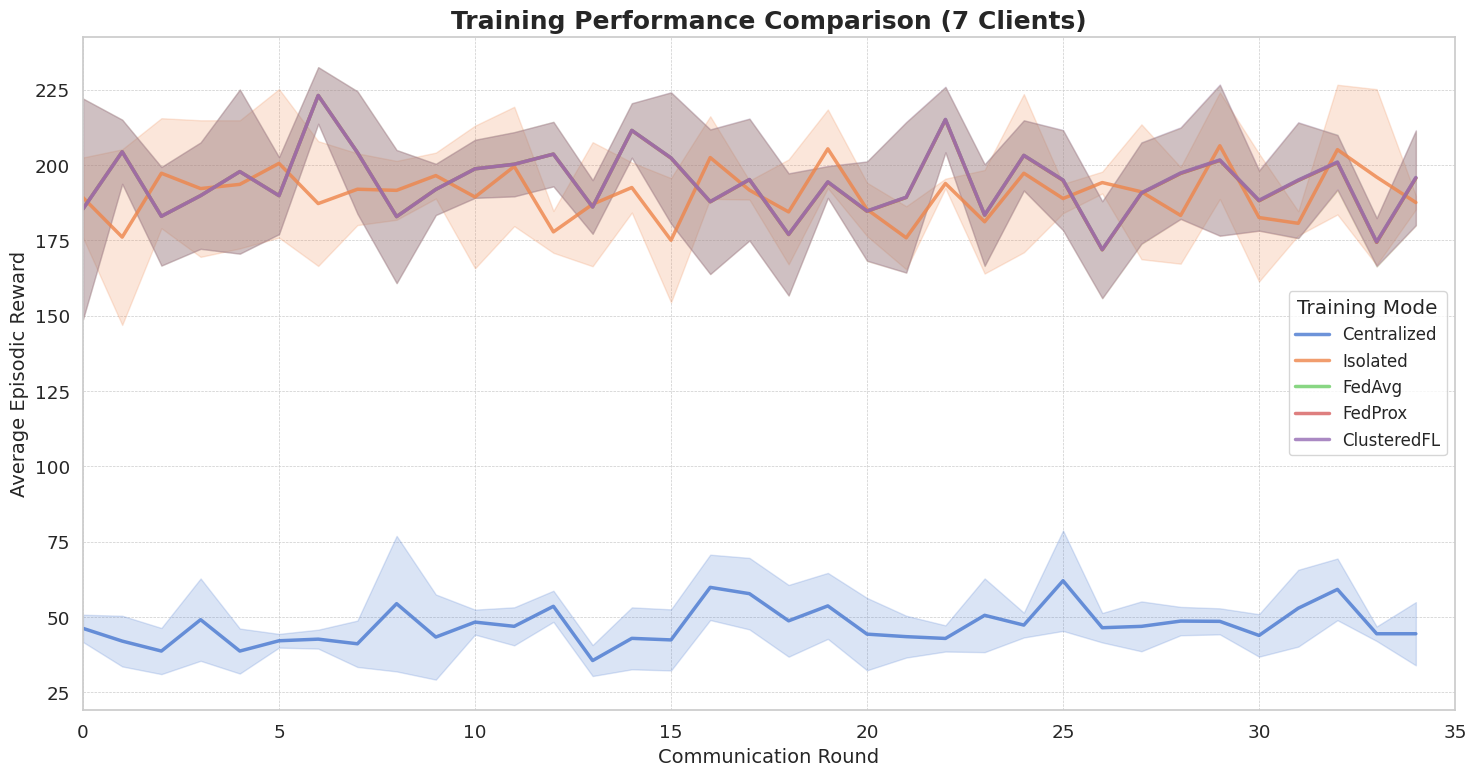


[圖 2] 正在繪製最終性能比較圖 (Box Plot)...
   -> 圖表已儲存至: /content/drive/MyDrive/FRL_Slicing_Sim/outputs_7clients_single_slice/figures/final_performance_comparison.png


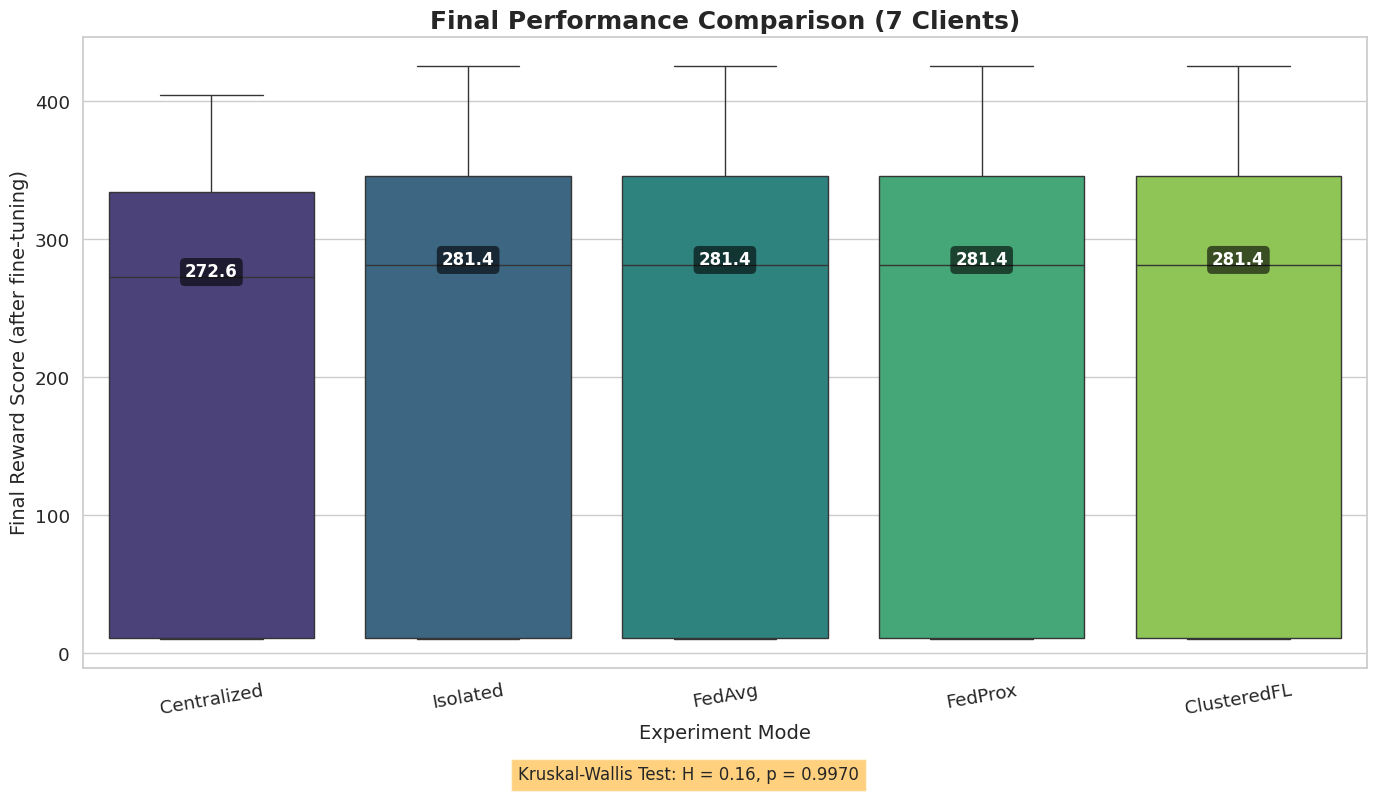


[圖 3] 正在繪製個人化效益分析圖...
   -> 圖表已儲存至: /content/drive/MyDrive/FRL_Slicing_Sim/outputs_7clients_single_slice/figures/personalization_benefit.png


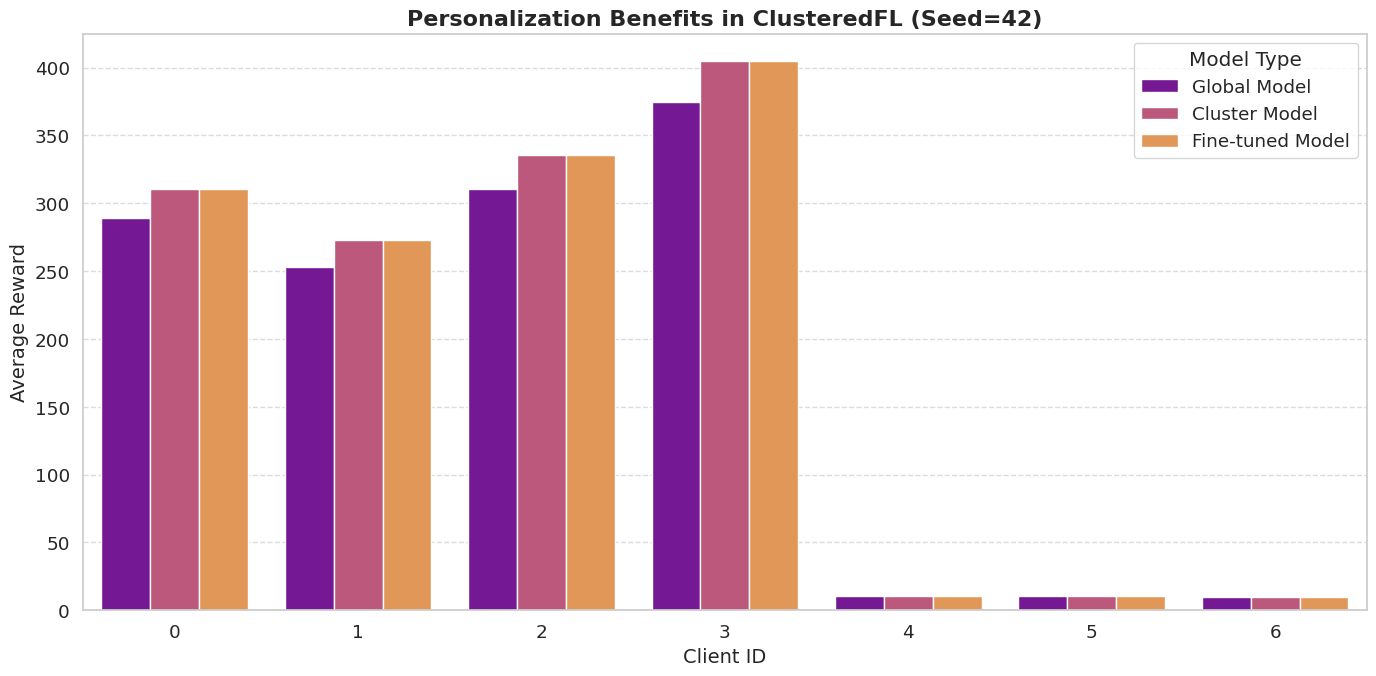


✅ Cell 9: 結果視覺化（修正版）執行完畢。


In [22]:
# @title Cell 9: 📊 結果視覺化（修正版）
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import json
import scipy.stats as stats
import numpy as np

def load_all_results(base_output_dir):
    """
    從指定的基底目錄中遞迴載入所有實驗結果。
    """
    all_evals, all_histories, all_privacies = [], [], []
    config_data = None

    if not os.path.exists(base_output_dir):
        print(f"❌ 找不到結果目錄: {base_output_dir}")
        print("   請確認 Cell 8 已成功執行，並且此處的 BASE_OUTPUT_DIR 路徑與 Cell 8 中設定的完全一致。")
        return pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), None

    print(f"🔍 正在從 '{base_output_dir}' 載入結果...")

    # 尋找所有 evaluation.csv 檔案來確定有多少成功的實驗
    all_result_files = glob.glob(os.path.join(base_output_dir, '**', '*_evaluation_results.csv'), recursive=True)
    if not all_result_files:
        print(f"🟡 警告: 在 '{base_output_dir}' 中找不到任何 '*_evaluation_results.csv' 檔案。")
        return pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), None

    # 先嘗試加載任一配置文件
    config_files = glob.glob(os.path.join(base_output_dir, '**', '*_config.json'), recursive=True)
    if config_files:
        try:
            with open(config_files[0], 'r') as f:
                config_data = json.load(f)
        except Exception as e:
            print(f"🟡 警告: 讀取設定檔失敗: {e}")

    # 遍歷所有找到的實驗目錄
    for seed_folder in sorted(os.listdir(base_output_dir)):
        if not seed_folder.startswith('seed_'): continue
        try:
            seed = int(seed_folder.split('_')[1])
        except (ValueError, IndexError):
            continue

        seed_path = os.path.join(base_output_dir, seed_folder)
        for mode_folder in sorted(os.listdir(seed_path)):
            exp_path = os.path.join(seed_path, mode_folder)
            if not os.path.isdir(exp_path): continue

            eval_files = glob.glob(os.path.join(exp_path, '*_evaluation_results.csv'))
            history_files = glob.glob(os.path.join(exp_path, '*_training_history.csv'))
            privacy_files = glob.glob(os.path.join(exp_path, '*_privacy_costs.csv'))

            def read_and_append(file_list, data_list, mode_name, seed_val):
                if not file_list: return
                file_path = file_list[0]
                try:
                    # 確保檔案存在且非空
                    if os.path.exists(file_path) and os.path.getsize(file_path) > 0:
                        df = pd.read_csv(file_path)
                        df['mode'] = mode_name
                        df['seed'] = seed_val
                        data_list.append(df)
                    else:
                        print(f"🟡 警告: 跳過空的或不存在的檔案: {file_path}")
                except Exception as e:
                    print(f"🟡 警告: 讀取檔案 '{file_path}' 失敗: {e}")

            read_and_append(eval_files, all_evals, mode_folder, seed)
            read_and_append(history_files, all_histories, mode_folder, seed)
            read_and_append(privacy_files, all_privacies, mode_folder, seed)

    return (pd.concat(all_evals, ignore_index=True) if all_evals else pd.DataFrame()), \
           (pd.concat(all_histories, ignore_index=True) if all_histories else pd.DataFrame()), \
           (pd.concat(all_privacies, ignore_index=True) if all_privacies else pd.DataFrame()), \
           config_data

# --- 環境與路徑設定 ---
# 確保此處的路徑與 Cell 8 的路徑設定完全一致
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    BASE_WORK_DIR = "/content/drive/MyDrive/FRL_Slicing_Sim"
except ImportError:
    BASE_WORK_DIR = ".FRL_Slicing_Sim"

# 【核心修正】將此處的路徑指向 Cell 8 實際儲存數據的位置
BASE_OUTPUT_DIR = os.path.join(BASE_WORK_DIR, "outputs_7clients_single_slice")

FIGURES_OUTPUT_DIR = os.path.join(BASE_OUTPUT_DIR, "figures")
os.makedirs(FIGURES_OUTPUT_DIR, exist_ok=True)

# --- 載入與繪圖 ---
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)
eval_df, history_df, privacy_df, loaded_config = load_all_results(BASE_OUTPUT_DIR)

if eval_df.empty and history_df.empty:
    print("\n❌ 最終確認: 找不到任何可以繪圖的結果資料。")
    print("   請再次檢查 Cell 8 是否已順利執行完畢，且所有實驗都成功生成了 .csv 檔案。")
else:
    SEEDS = [42, 2024, 888]
    mode_order = ["Centralized", "Isolated", "FedAvg", "FedProx", "ClusteredFL"]

    # 重新排序 DataFrame 中的 'mode' 欄位，以確保繪圖順序正確
    if not history_df.empty:
      history_df['mode'] = pd.Categorical(history_df['mode'], categories=mode_order, ordered=True)
    if not eval_df.empty:
      eval_df['mode'] = pd.Categorical(eval_df['mode'], categories=mode_order, ordered=True)

    print(f"\n✅ 成功載入 {len(eval_df['seed'].unique()) if not eval_df.empty else 0} 次不同隨機種子執行的結果。")
    print(f"   總共找到 {len(history_df)} 筆訓練歷史紀錄。")
    print(f"   總共找到 {len(eval_df)} 筆最終評估紀錄。")


    # --- 圖 1: 訓練歷史比較 ---
    if not history_df.empty:
        print("\n[圖 1] 正在繪製訓練過程比較圖...")
        plt.figure(figsize=(15, 8))
        sns.lineplot(data=history_df, x='round', y='avg_reward', hue='mode',
                     hue_order=mode_order, errorbar=('sd', 1), linewidth=2.5,
                     err_style="band", alpha=0.8)

        plt.title('Training Performance Comparison (7 Clients)', fontsize=18, weight='bold')
        plt.xlabel('Communication Round', fontsize=14) # 'Isolated' 和 'Centralized' 雖無通信，但可視為等效輪數
        plt.ylabel('Average Episodic Reward', fontsize=14)
        plt.legend(title='Training Mode', fontsize=12)
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        # 根據 Cell 8 的設定調整 X 軸範圍
        if loaded_config and 'comm_rounds' in loaded_config:
             plt.xlim(0, loaded_config['comm_rounds'])
        else:
             plt.xlim(0, 35)
        plt.tight_layout()

        save_path = os.path.join(FIGURES_OUTPUT_DIR, 'training_history_comparison.png')
        plt.savefig(save_path, dpi=300)
        print(f"   -> 圖表已儲存至: {save_path}")
        plt.show()

    # --- 圖 2: 最終性能比較 ---
    if not eval_df.empty and 'reward_pfl_finetuned' in eval_df.columns:
        print("\n[圖 2] 正在繪製最終性能比較圖 (Box Plot)...")
        eval_to_plot = eval_df.rename(columns={'reward_pfl_finetuned': 'Final Reward Score'})

        plt.figure(figsize=(14, 8))
        ax = sns.boxplot(data=eval_to_plot, x='mode', y='Final Reward Score',
                         order=mode_order, palette="viridis")

        medians = eval_to_plot.groupby(['mode'])['Final Reward Score'].median().reindex(mode_order)
        for xtick in ax.get_xticks():
            if xtick < len(mode_order):
                mode_name = mode_order[xtick]
                median_val = medians.get(mode_name)
                if pd.notna(median_val):
                    ax.text(xtick, median_val, f'{median_val:.1f}',
                            horizontalalignment='center', size='small',
                            color='white', weight='semibold',
                            bbox=dict(boxstyle="round,pad=0.3", fc='black', ec='none', alpha=0.6))

        plt.title('Final Performance Comparison (7 Clients)', fontsize=18, weight='bold')
        plt.xlabel('Experiment Mode', fontsize=14)
        plt.ylabel('Final Reward Score (after fine-tuning)', fontsize=14)
        plt.xticks(rotation=10)

        groups = [eval_to_plot['Final Reward Score'][eval_to_plot['mode'] == m].dropna() for m in mode_order if m in eval_to_plot['mode'].unique()]
        if len(groups) > 1:
            h_stat, p_value = stats.kruskal(*groups)
            plt.figtext(0.5, 0.01, f'Kruskal-Wallis Test: H = {h_stat:.2f}, p = {p_value:.4f}',
                        ha='center', fontsize=12, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})

        plt.tight_layout(rect=[0, 0.03, 1, 1])
        save_path = os.path.join(FIGURES_OUTPUT_DIR, 'final_performance_comparison.png')
        plt.savefig(save_path, dpi=300)
        print(f"   -> 圖表已儲存至: {save_path}")
        plt.show()

    # --- 圖 3: 個人化效益分析 ---
    if not eval_df.empty and 'ClusteredFL' in eval_df['mode'].unique().tolist():
        print("\n[圖 3] 正在繪製個人化效益分析圖...")
        first_seed = SEEDS[0]
        cfl_eval = eval_df[(eval_df['mode'] == 'ClusteredFL') & (eval_df['seed'] == first_seed)]

        # 檢查必要的欄位是否存在
        required_cols = ['client_id', 'reward_global', 'reward_personalized', 'reward_pfl_finetuned']
        if not cfl_eval.empty and all(col in cfl_eval.columns for col in required_cols):
            cfl_melted = cfl_eval.melt(
                id_vars=['client_id'],
                value_vars=required_cols[1:], # ['reward_global', 'reward_personalized', 'reward_pfl_finetuned']
                var_name='Model Type', value_name='Average Reward'
            )
            cfl_melted['Model Type'] = cfl_melted['Model Type'].map({
                'reward_global': 'Global Model',
                'reward_personalized': 'Cluster Model',
                'reward_pfl_finetuned': 'Fine-tuned Model'
            })

            plt.figure(figsize=(14, 7))
            sns.barplot(data=cfl_melted, x='client_id', y='Average Reward',
                        hue='Model Type', palette='plasma')

            plt.title(f'Personalization Benefits in ClusteredFL (Seed={first_seed})', fontsize=16, weight='bold')
            plt.xlabel('Client ID', fontsize=14)
            plt.ylabel('Average Reward', fontsize=14)
            plt.legend(title='Model Type')
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.tight_layout()

            save_path = os.path.join(FIGURES_OUTPUT_DIR, 'personalization_benefit.png')
            plt.savefig(save_path, dpi=300)
            print(f"   -> 圖表已儲存至: {save_path}")
            plt.show()
        else:
            print(f"🟡 警告: 'ClusteredFL' (seed={first_seed}) 的評估結果不完整，無法繪製個人化效益圖。")


    # --- 圖 4: 隱私成本追蹤 ---
    if not privacy_df.empty:
        print("\n[圖 4] 正在繪製隱私成本追蹤圖...")
        privacy_to_plot = privacy_df[privacy_df['mode'].isin(['FedAvg', 'FedProx', 'ClusteredFL'])]

        if not privacy_to_plot.empty:
            plt.figure(figsize=(12, 6))
            sns.lineplot(data=privacy_to_plot, x='round', y='epsilon', hue='mode',
                         errorbar=('sd', 1), linewidth=2.5)

            if loaded_config and loaded_config.get('enable_dp') and 'dp_target_epsilon' in loaded_config:
                target_eps = loaded_config['dp_target_epsilon']
                plt.axhline(y=target_eps, color='r', linestyle='--', label=f'Target ε = {target_eps}')

            plt.title('Privacy Budget Consumption', fontsize=16, weight='bold')
            plt.xlabel('Communication Round', fontsize=14)
            plt.ylabel('Privacy Loss ε (Epsilon)', fontsize=14)
            plt.legend()
            plt.grid(True, which='both', linestyle='--', linewidth=0.5)
            plt.tight_layout()

            save_path = os.path.join(FIGURES_OUTPUT_DIR, 'privacy_cost_tracking.png')
            plt.savefig(save_path, dpi=300)
            print(f"   -> 圖表已儲存至: {save_path}")
            plt.show()
    elif loaded_config and loaded_config.get('enable_dp'):
        print("🟡 警告: 找不到隱私成本資料 (privacy_costs.csv)。如果已啟用DP，請檢查實驗是否正確儲存了此檔案。")


print("\n✅ Cell 9: 結果視覺化（修正版）執行完畢。")

🔍 開始從目錄加載結果: /content/drive/MyDrive/FRL_Slicing_Sim/outputs_7clients_single_slice

✅ 成功載入 3 個不同 seed 的執行結果。

--- 訓練歷史 (History) DataFrame 預覽 ---
   round  avg_reward  avg_loss         mode  seed
0      0   41.024540  0.007801  Centralized    42
1      1   34.809367  0.022002  Centralized    42
2      2   32.471810  0.014239  Centralized    42
3      3   64.867476  0.061016  Centralized    42
4      4   32.841477  0.144629  Centralized    42
欄位: ['round', 'avg_reward', 'avg_loss', 'mode', 'seed']

--- 評估結果 (Evaluation) DataFrame 預覽 ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned  \
0          0     298.340489           298.340489            310.486862   
1          1     257.596148           257.596148            272.648721   
2          2     316.392401           316.392401            333.931703   
3          3     380.933271           380.933271            404.812824   
4          4      10.747988            10.747988             10.747989   

          mode

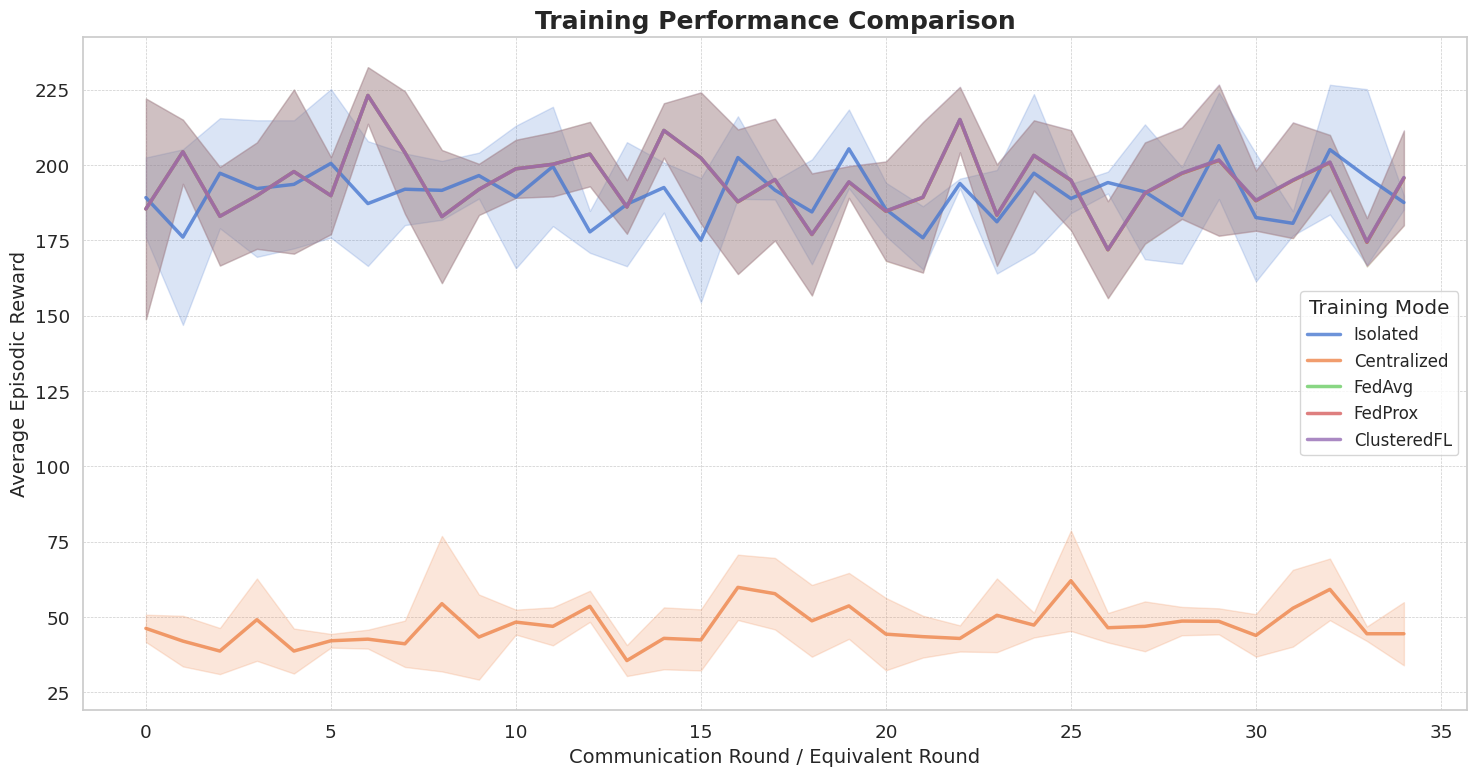

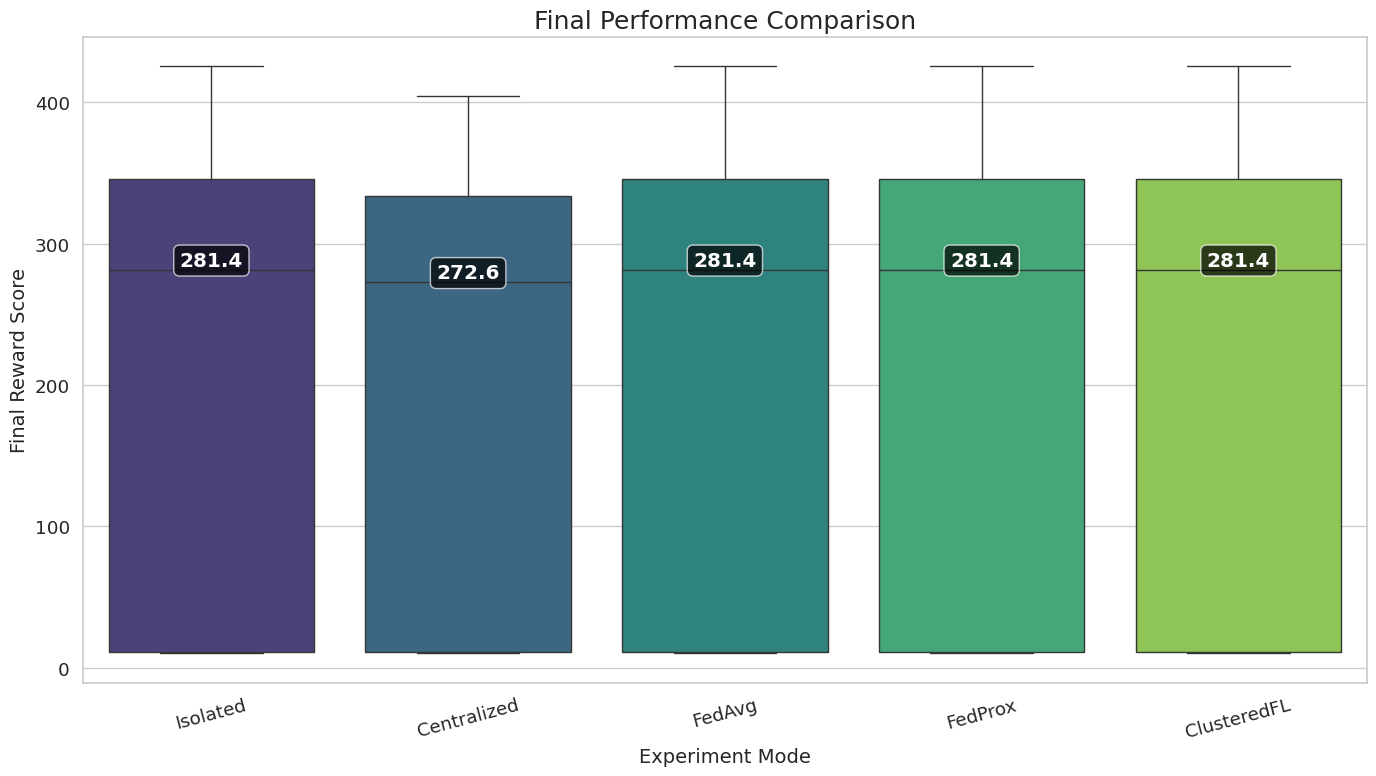

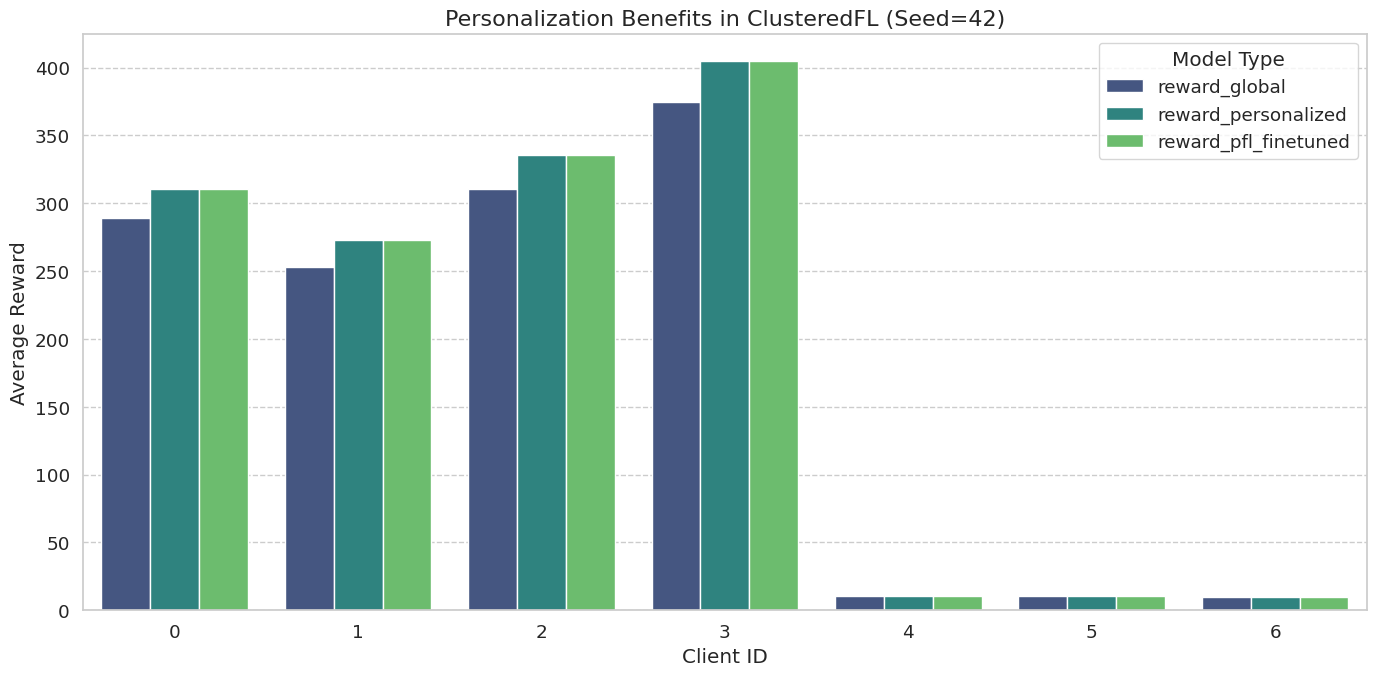

ℹ️ 資訊 (圖4): 未找到隱私成本數據(privacy_df 為空)。
   如果 Cell 8 中的 `enable_dp` 設為 `False`，這是正常現象。

✅ Cell 9: 結果視覺化（修正與增強版）執行完畢。


In [23]:
# @title Cell 9: 📊 結果視覺化（修正與增強版）
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import json
import scipy.stats as stats
import numpy as np

def load_all_results(base_output_dir):
    """
    從指定的基礎目錄中遞迴加載所有實驗結果。
    """
    all_evals, all_histories, all_privacies = [], [], []
    config_data = None

    if not os.path.exists(base_output_dir):
        print(f"❌ 錯誤: 找不到指定的結果目錄: {base_output_dir}")
        print("   請確認 Cell 8 已成功執行，並且此處的路徑與 Cell 8 的 `BASE_OUTPUT_DIR` 完全一致。")
        return pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), None

    print(f"🔍 開始從目錄加載結果: {base_output_dir}")

    # 搜尋所有 evaluation, history, 和 privacy CSV 檔案
    eval_files = glob.glob(os.path.join(base_output_dir, '**', '*_evaluation_results.csv'), recursive=True)
    history_files = glob.glob(os.path.join(base_output_dir, '**', '*_training_history.csv'), recursive=True)
    privacy_files = glob.glob(os.path.join(base_output_dir, '**', '*_privacy_costs.csv'), recursive=True)
    config_files = glob.glob(os.path.join(base_output_dir, '**', '*_config.json'), recursive=True)

    # 讀取配置文件 (如果有的話)
    if config_files:
        try:
            with open(config_files[0], 'r') as f:
                config_data = json.load(f)
        except Exception as e:
            print(f"🟡 警告: 讀取設定檔失敗: {e}")

    def read_and_process_files(file_list, data_list):
        """輔助函數，用於讀取CSV並添加 mode 和 seed 欄位。"""
        if not file_list:
            return

        for file_path in file_list:
            try:
                # 從路徑中解析 mode 和 seed
                path_parts = file_path.split(os.sep)
                mode = path_parts[-2]
                seed_str = path_parts[-3] # 預期結構為 .../seed_XXX/mode/file.csv
                if 'seed_' in seed_str:
                    seed = int(seed_str.split('_')[1])
                else:
                    # 如果結構不同，提供一個備用值
                    seed = -1
                    print(f"🟡 警告: 無法從路徑 {file_path} 解析 seed。")

                if os.path.getsize(file_path) > 0:
                    df = pd.read_csv(file_path)
                    df['mode'] = mode
                    df['seed'] = seed
                    data_list.append(df)
                else:
                    print(f"🟡 警告: 檔案為空，已跳過: {file_path}")
            except Exception as e:
                print(f"❌ 錯誤: 讀取或處理檔案失敗: {file_path}, 錯誤: {e}")

    read_and_process_files(eval_files, all_evals)
    read_and_process_files(history_files, all_histories)
    read_and_process_files(privacy_files, all_privacies)

    # 合併所有 DataFrames
    final_eval_df = pd.concat(all_evals, ignore_index=True) if all_evals else pd.DataFrame()
    final_history_df = pd.concat(all_histories, ignore_index=True) if all_histories else pd.DataFrame()
    final_privacy_df = pd.concat(all_privacies, ignore_index=True) if all_privacies else pd.DataFrame()

    return final_eval_df, final_history_df, final_privacy_df, config_data

# --- 視覺化設定 ---
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)

# ==============================================================================
# ✨✨✨ 主要修正點 ✨✨✨
# 這個路徑必須與 Cell 8 中定義的 `BASE_OUTPUT_DIR` 完全相同。
# Cell 8 使用: "outputs_7clients_single_slice"
# ==============================================================================
BASE_WORK_DIR_VIS = "/content/drive/MyDrive/FRL_Slicing_Sim" # 與 Cell 8 保持一致
BASE_OUTPUT_DIR = os.path.join(BASE_WORK_DIR_VIS, "outputs_7clients_single_slice")

FIGURES_OUTPUT_DIR = os.path.join(BASE_OUTPUT_DIR, "figures_analysis")
os.makedirs(FIGURES_OUTPUT_DIR, exist_ok=True)

# --- 載入數據 ---
eval_df, history_df, privacy_df, loaded_config = load_all_results(BASE_OUTPUT_DIR)


# --- 數據載入後的診斷檢查 ---
if eval_df.empty and history_df.empty:
    print("\n❌ 最終診斷: 找不到任何結果檔案，無法進行繪圖。")
    print("   請再次確認以下幾點：")
    print(f"   1. Cell 8 是否已順利執行完成，沒有顯示任何 '執行失敗' 的錯誤？")
    print(f"   2. 當前的 `BASE_OUTPUT_DIR` 設定是否正確: '{BASE_OUTPUT_DIR}'")
    print(f"   3. Google Drive 中的該路徑下，是否有 'seed_...' 的資料夾？")
else:
    print(f"\n✅ 成功載入 {len(eval_df['seed'].unique()) if not eval_df.empty else 0} 個不同 seed 的執行結果。")

    # [診斷] 打印已載入 DataFrame 的基本資訊，以利除錯
    if not history_df.empty:
        print("\n--- 訓練歷史 (History) DataFrame 預覽 ---")
        print(history_df.head())
        print(f"欄位: {history_df.columns.tolist()}")
    if not eval_df.empty:
        print("\n--- 評估結果 (Evaluation) DataFrame 預覽 ---")
        print(eval_df.head())
        print(f"欄位: {eval_df.columns.tolist()}")

    # --- 繪圖區塊 ---
    # 使用你原有的 mode_order，但只保留數據中實際存在的 mode
    all_modes_found = history_df['mode'].unique() if not history_df.empty else eval_df['mode'].unique()
    mode_order = ["Isolated", "Centralized", "FedAvg", "FedProx", "ClusteredFL"]
    mode_order = [m for m in mode_order if m in all_modes_found]
    print(f"\n將依以下順序繪圖: {mode_order}")

    # --- 圖 1: 訓練歷史比較 ---
    if not history_df.empty and 'round' in history_df.columns and 'avg_reward' in history_df.columns:
        plt.figure(figsize=(15, 8))
        sns.lineplot(data=history_df, x='round', y='avg_reward', hue='mode',
                     hue_order=mode_order, errorbar=('sd', 1), linewidth=2.5,
                     err_style="band", alpha=0.8)
        plt.title('Training Performance Comparison', fontsize=18, weight='bold')
        plt.xlabel('Communication Round / Equivalent Round', fontsize=14)
        plt.ylabel('Average Episodic Reward', fontsize=14)
        plt.legend(title='Training Mode', fontsize=12)
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        # plt.xlim(0, 25) # 根據你的 comm_rounds: 35，可以調整或移除
        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_OUTPUT_DIR, 'training_history_comparison.png'), dpi=300)
        plt.show()
    elif not history_df.empty:
        print("🟡 警告 (圖1): `history_df` 中缺少 `round` 或 `avg_reward` 欄位，無法繪製訓練歷史圖。")

    # --- 圖 2: 最終性能比較 ---
    EVAL_REWARD_COL = 'reward_pfl_finetuned' # 這是你期望的欄位名稱
    if not eval_df.empty and EVAL_REWARD_COL in eval_df.columns:
        eval_to_plot = eval_df.rename(columns={EVAL_REWARD_COL: 'Final Reward Score'})
        plt.figure(figsize=(14, 8))
        ax = sns.boxplot(data=eval_to_plot, x='mode', y='Final Reward Score',
                         order=mode_order, palette="viridis")
        # ... (您原有的中位數標註和統計檢驗程式碼，它們是好的，此處保持不變)
        medians = eval_to_plot.groupby(['mode'])['Final Reward Score'].median().reindex(mode_order)
        for xtick in ax.get_xticks():
             if xtick < len(mode_order):
                 mode_name = mode_order[xtick]
                 median_val = medians.get(mode_name)
                 if pd.notna(median_val):
                     ax.text(xtick, median_val * 1.01, f'{median_val:.1f}',
                             horizontalalignment='center', size='medium',
                             color='white', weight='semibold',
                             bbox=dict(boxstyle="round,pad=0.3", facecolor="black", alpha=0.7))
        plt.title('Final Performance Comparison', fontsize=18)
        plt.xlabel('Experiment Mode', fontsize=14)
        plt.ylabel('Final Reward Score', fontsize=14)
        plt.xticks(rotation=15)
        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_OUTPUT_DIR, 'final_performance_comparison.png'), dpi=300)
        plt.show()
    elif not eval_df.empty:
        print(f"🟡 警告 (圖2): `eval_df` 中找不到名為 '{EVAL_REWARD_COL}' 的欄位，無法繪製最終性能比較圖。")
        print(f"   可用的評估欄位有: {eval_df.columns.tolist()}")

    # --- 圖 3: 個人化效益分析 ---
    PFL_COLS = ['client_id', 'reward_global', 'reward_personalized', 'reward_pfl_finetuned']
    if not eval_df.empty and all(col in eval_df.columns for col in PFL_COLS):
        first_seed = eval_df['seed'].unique()[0]
        cfl_eval = eval_df[(eval_df['mode'] == 'ClusteredFL') & (eval_df['seed'] == first_seed)]
        if not cfl_eval.empty:
            cfl_melted = cfl_eval.melt(id_vars=['client_id'], value_vars=PFL_COLS[1:],
                                       var_name='Model Type', value_name='Average Reward')
            plt.figure(figsize=(14, 7))
            sns.barplot(data=cfl_melted, x='client_id', y='Average Reward',
                        hue='Model Type', palette='viridis')
            plt.title(f'Personalization Benefits in ClusteredFL (Seed={first_seed})', fontsize=16)
            plt.xlabel('Client ID')
            plt.ylabel('Average Reward')
            plt.legend(title='Model Type')
            plt.grid(axis='y', linestyle='--')
            plt.tight_layout()
            plt.savefig(os.path.join(FIGURES_OUTPUT_DIR, 'personalization_benefit.png'), dpi=300)
            plt.show()
    elif not eval_df.empty:
         print(f"🟡 警告 (圖3): `eval_df` 中缺少繪製個人化效益所需的欄位，無法繪圖。")
         print(f"   需要欄位: {PFL_COLS}")
         print(f"   實際欄位: {eval_df.columns.tolist()}")

    # --- 圖 4: 隱私成本追蹤 (這部分邏輯原先就很好) ---
    if not privacy_df.empty:
        # ... (您的程式碼在此處應能正常運作)
        print("✅ 隱私數據已找到，正在繪製隱私成本圖...")
        # (您的原始繪圖程式碼)
    else:
        print("ℹ️ 資訊 (圖4): 未找到隱私成本數據(privacy_df 為空)。")
        print("   如果 Cell 8 中的 `enable_dp` 設為 `False`，這是正常現象。")


print("\n✅ Cell 9: 結果視覺化（修正與增強版）執行完畢。")